<h1>Assignment 2</h1>

<h2>Due: Mon 04 Jan 2021 Midnight</h2>
<a href='http://www.cs.bgu.ac.il/~elhadad/nlp21.html'>Natural Language Processing - Fall 2021 Michael Elhadad</a>
<p/>
This assignment covers the topic of document classification, sequence classification, named entity recognition and word embeddings.
The objective is:
<ul>
<li>Apply feature-based supervised machine learning methods for document and token classification.</li>
<li>Investigate algorithms for sequence classification: HMMs and CRFs.</li>
<li>Learn the specific tasks of word classification, named entity recognition and document classification.
<li>Use pre-trained word embeddings and measure whether they help for the task of NER.
</ul>

<p/>
Submit your solution by email in the form of an iPython ipynb file.
<p/>
Do <b>not</b> attach the data in your submission.  Your notebook should refer to the data folder as "../data".

<p>
</p><hr>
<h2>Content</h2>
<ul>
    <li><a href="#questions">Q1. Questions Classification</a>
      <ul>
      <li><a href="#q1.1">Q1.1. Describe the dataset qualitatively</a></li>
      <li><a href="#q1.2">Q1.2. Dataset Reader</a></li>
      <li><a href="#q1.3">Q1.3. Dataset Exploration</a></li>
      <li><a href="#q1.4">Q1.4. Classifier Interface, Evaluation Metrics, Confusion Matrix</a></li>
      <li><a href="#q1.5">Q1.5 Baseline Classifier</a></li>
      <li><a href="#q1.6">Q1.6 Features-based Classifier</a></li>
      <li><a href="#q1.7">Q1.7. Optional</a></li>
      </ul>
    </li>
    <li><a href="#q2">Q2. Document Classification</a>
      <ul>
        <li><a href="#q2.1">Q2.1 Reuters Dataset</a>
          <ul>
          <li><a href="#q2.1.1">Q2.1.1 Descriptive Statistics</a></li>
          <li><a href="#q2.1.2">Q2.1.2 Partial-fit classifiers</a></li>
          <li><a href="#q2.1.3">Q2.1.3 Hashing Vectorizer</a></li>
          </ul>
        </li>
        <li><a href="#q2.2">Q2.2. BBC News Dataset</a>
          <ul>
            <li><a href="#q2.2.1">Q2.2.1 Descriptive Statistics</a></li>
            <li><a href="#q2.2.2">Q2.2.2 Feature Extraction</a></li>
            <li><a href="#q2.2.3">Q2.2.3 Model Training and Evaluation</a></li>
            </ul>
        </li>
      </ul>
    </li>
    <li><a href="#q3">Q3. Named Entity Recognition</a>
      <ul>
        <li><a href="#q3.1">Q3.1 Features</a>
          <ul>
            <li><a href="#q3.1.1">Q3.1.1 Feature Extraction</a></li>
            <li><a href="#q3.1.2">Q3.1.2 Model Training</a></li>
            <li><a href="#q3.1.3">Q3.1.3 Greedy Tagging vs. Sequence Tagging</a></li>
          </ul>
        </li>
        <li><a href="#q3.2">Q3.2 Using Word Embeddings</a></li>
      </ul>
</ul>


In [2]:
# imports
import glob
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

In [3]:
# helper class to print nice outputs
class txt:
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def make_bold(text):
    return txt.BOLD+ text + txt.END

def make_underline(text):
    return txt.UNDERLINE+ text + txt.END

<hr/>
<a name="questions"></a>
<h2>Q1. Questions Classification</h2>

Consider the dataset on Question Classification available <a href="https://cogcomp.seas.upenn.edu/Data/QA/QC/">here</a>.

<a name="q1.1"></a>
<h3>Q1.1. Describe the dataset qualitatively</h3>

Read the article introducing this dataset: 
<a href="http://www.aclweb.org/anthology/C02-1150">in Li, Dan Roth, Learning Question Classifiers. COLING'02</a>.
<p/>
Write a half to one-page summary of the paper, focusing on the dataset description (more than on the description of the classifier introduced in the paper).
Describe the exact task, the labels used, and provide the motivation for this task.
Provide examples for the 6 main categories.


<a name="q1.2"></a>
<h3>Q1.2. Dataset Reader</h3>

Implement a reader to parse the dataset into a data structure that will be easily used for scikit-learn processing.

Adapt the code we used in HW1:


This article deals with machine learning approach to classify questions. <br> 
The idea is that given a WH-question the machine should be able to categorize the question to a semantic class that impose constraints on potential answer. This task is considered a multi label classification. <br> <br> 
The motivation – to answer a question, one need to understand it and recognize the field (class) of the question. Most question answering systems have no more than 20 different classes, that is because there is a lot of manual work to do to build a classifier for a complicated taxonomy of questions. <br> 
In this case, the approach was a multi-level learning approach – some features rely on finer analysis of the outcome's questions of the learned classifier, and the QC nodule applies learning with this input.<br> 
They defined two-layered taxonomy, the hierarchy has 6 coarse classes (ABBREVIATION, ENTITY, DESCRIPTION, HUMAN, LOCATION, NUMERIC VALUE) and 50 fine classes, where each coarse class contains a non-overlapping set of fine classes. <br> 
One problem was the ambiguity between different classes, some questions can fit to more than 1 class, that is why they chose multi-label classification, which also allowed in the processing step to apply all classes without loss.<br> <br> 
Each question is analyzed and represented as list of features, the dataset for learning. The types of features are words, pos, tags, chunks, named entities, head chunks and semantically related words. Over these features they composed more complexed features such as conjunctive and relational. The features are extracted from the data, only "active" ones appear in the representation. Some of the features are syntactic and others semantic.<br> 
Given a question and confusion set, the output is a density over the classes, by the activation of each one. Then each class is ranked in a decreasing order by the density and we get the labels with their probabilities.  <br> <br> 
There were 2 experiments, one to evaluate the contribution of different feature types to the quality of the classification, and the second to evaluate the advantage they get from the hierarchical classifier. <br> 
The data was collected from 4 different sources of question in English. <br> They were manually labeled according to the hierarchy. 
The number of correct classifications was count in 2 precision standards, 
\begin{equation*}
p_1 \text{  and  }  p_{\le5}.
\end{equation*}

If: 
\begin{equation*}
\left (I_i,j= \{1,  \text{  if the correct label of the ith question is output in rank  } \\j_0,  \text{  otherwise  } \right)
\end{equation*}


Then: 
\begin{equation*}
\left (P_1=\sum_{i=1}^{m}{I_{i,1}/m} \text{   AND   } (p_{\le5}=\sum_{i=1}^{m}\sum_{j}^{k_i}{I_{i,1}/m} \right )
\end{equation*}


<br> 
The results showed there is a tradeoff between smaller confusion set and the inaccuracy, albeit small, of the coarse level prediction. There is no performance advantage for using a level of coarse classes, and the semantically appealing coarse classes do not contribute to better performance. Question classification problem can be solved quite accurately with a learning approach and exhibit the benefits of features based on semantic analysis.<br> 
<br> 
examples for the main categories:
* Location: What country do the Galapagos Islands belong to?
* Human: Who discovered electricity?
* Entity: What is a female rabbit called?
* Numeric value: How many bends are there in a standard paper clip?
* Description: What is titanium? 
* Abbreviation: What is the full form of .com? 


In [4]:
import codecs
import math
import random
import string
import time
import numpy as np
from sklearn.metrics import accuracy_score

'''
Define different constants for the task of question classification 
based on the definition of the task.
In the question classification case, there are 2 labels per question: coarse and fine.
'''
coarse_categories = ["ABBREVIATION", "ENTITY", "DESCRIPTION", "HUMAN", "LOCATION", "NUMERIC VALUE"]
fine_categories = {}
fine_categories["ABBREVIATION"] = ["abb", "exp"]
fine_categories["ENTITY"] = ["animal", "body", "color", "creative", "currency", "dis.med.", "event", "food", "instrument", "lang", "letter", "other", "plant", "product", "religion", "sport", "substance", "symbol", "technique", "term", "vehicle", "word"]
fine_categories["DESCRIPTION"] = ["definition", "description", "manner", "reason"]
fine_categories["HUMAN"] = ["group", "ind", "title", "description"]
fine_categories["LOCATION"] = ["city", "country", "mountain", "other", "state"]
fine_categories["NUMERIC"] = ["code", "count", "date", "distance", "money", "order", "other", "period", "percent", "speed", "temp", "size", "weight"]
# @Todo more here...

# Build the category_lines dictionary, a list of names per language
coarse_category_lines = {}
all_categories = []

# @Todo: Define the way the lines should be parsed
def parseLine(line):
     return [line[:line.index(':')], line[(line.index(':') + 1): line.index(' ')], line[(line.index(' ') + 1):]]
    # return line

# @Todo: Read a file and split into lines - create the appropriate data structure
def readLines(filename):
  lines = codecs.open(filename, "r",encoding='utf-8', errors='ignore').read().strip().split('\n')
  return [parseLine(line) for line in lines]

In [5]:
def findFiles(path): return glob.glob(path)
# run over all files in train folder
for filename in findFiles('data/questions/train/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    # split the ducument into lines
    lines = readLines(filename)
    coarse_category_lines[category] = lines

In [12]:
len(coarse_category_lines['train_2000.label'])

2000

Let's take a look how the data is represented now:

In [13]:
coarse_category_lines['train_1000.label'][:10]

[['DESC', 'manner', 'How did serfdom develop in and then leave Russia ?'],
 ['ENTY', 'cremat', 'What films featured the character Popeye Doyle ?'],
 ['DESC', 'manner', "How can I find a list of celebrities ' real names ?"],
 ['ENTY',
  'animal',
  'What fowl grabs the spotlight after the Chinese Year of the Monkey ?'],
 ['ABBR', 'exp', 'What is the full form of .com ?'],
 ['HUM', 'ind', 'What contemptible scoundrel stole the cork from my lunch ?'],
 ['HUM', 'gr', "What team did baseball 's St. Louis Browns become ?"],
 ['HUM', 'title', 'What is the oldest profession ?'],
 ['DESC', 'def', 'What are liver enzymes ?'],
 ['HUM', 'ind', 'Name the scar-faced bounty hunter of The Old West .']]

<a name="q1.3"></a>
<h3>Q1.3. Dataset Exploration</h3>

The labels used to classify the questions are organized in two levels:
<ul>
<li>6 coarse classes (ABBREVIATION, ENTITY, DESCRIPTION, HUMAN, LOCATION and NUMERIC VALUE)
<li>50 fine classes (see Table 1 of the article above)
</ul>

The definition of the question labels is provided <a href="https://cogcomp.seas.upenn.edu/Data/QA/QC/definition.html">here</a>.
<p/>

Provide a quantitative description of the dataset:
<ol>
<li>Distribution of the question labels (number / percentage) - separately for coarse and fine labels.
<li>Distribution of the number of tokens per question - overall and per label.
<li>Vocabulary size and number of tokens overall and per label.
<li>Top 20 more frequent words overall and per label
<li>Number of words occurring 1,2,3,4 and 5 times
</ol>

For this type of exploration, the <a href="https://pandas.pydata.org/">pandas</a> library is extremely convenient.
In particular, explore the function dataframe.describe().  You can use other code if you prefer.


In [6]:
labels_questions = list(coarse_category_lines.values())
labels_questions = [item for sublist in labels_questions for item in sublist]
df = pd.DataFrame.from_records(labels_questions,columns=['coarse','fine','question'])
df.head()

,coarse,fine,question
0,DESC,manner,How did serfdom develop in and then leave Russ...
1,ENTY,cremat,What films featured the character Popeye Doyle ?
2,DESC,manner,How can I find a list of celebrities ' real na...
3,ENTY,animal,What fowl grabs the spotlight after the Chines...
4,ABBR,exp,What is the full form of .com ?


In [7]:
def add_num_of_tokens(df):
    tokens=[]
    for i in range(len(df.index)):
        tokens.append(len(df.loc[i]['question'].split(" ")))
    df2=df.copy()
    df2['num_of_tokens']=tokens
    return df2

In [8]:
def add_vocab_size(df,category,statistics_df):
    vocabs={}
    lens=[]

    for x in df.groupby([category]):
        vocabs[x[0]]=set()

    for x in df.groupby([category]):
        questions=x[1]['question'].tolist()
        for q in questions:
            vocabs[x[0]]=vocabs[x[0]].union(set(q.split(" ")))

    for x in df.groupby([category]):
        lens.append(len(vocabs[x[0]]))

    statistics_df['vocab size']=lens


In [9]:
def get_statistics(df,type_catrgory,categories):
    all_question = len(df.index)
    df2=add_num_of_tokens(df)
    category_statistics=df2.groupby([type_catrgory]).agg({'question':'count','num_of_tokens':'sum'})
    category_statistics['percentage']=category_statistics['question']/all_question
    category_statistics=category_statistics.rename(columns={'question':'num of question'})
    add_vocab_size(df2,type_catrgory,category_statistics)
    return category_statistics

def plot_statistics(category_statistics,resize=False):
    if resize:
        plt.figure(figsize=(20,5))
    
    fig=category_statistics['num of question'].plot.bar()
    fig.set_title('number of question per category')
    fig.set_ylabel('number of question')
    plt.show()
    
    if resize:
        plt.figure(figsize=(20,5))
    fig=category_statistics['num_of_tokens'].plot.bar()
    fig.set_title('number of tokens per category')
    fig.set_ylabel('number of tokens')
    plt.show()
    
    if resize:
        plt.figure(figsize=(20,5))
    fig=category_statistics['vocab size'].plot.bar()
    fig.set_title('vocab size per category')
    fig.set_ylabel('vocab size')

In [10]:
from collections import Counter
def top_tokens_per_categoty(all_questions, top,category_type):
    tokens_per_tag={}
    for coarse_tag,fine_tag,question in all_questions:
        quest_tokens = question.lower().split(" ")
        tag=coarse_tag if category_type=='coarse' else fine_tag
        if tag not in tokens_per_tag:
            tokens_per_tag[tag] = Counter()
        for token in quest_tokens:
            if token !='?':
                tokens_per_tag[tag][token] += 1
    return pd.DataFrame({tag:counter.most_common(top) for tag,counter in tokens_per_tag.items() if tag!='currency'})


### Distribution per category

#### Coarse categoty

In [11]:
coarse_categories = ['ABBR','ENTY','DESC','HUM','LOC','NUM']
coarse_statistics=get_statistics(df,'coarse',coarse_categories)
coarse_statistics

,num of question,num_of_tokens,percentage,vocab size
coarse,,,,
ABBR,241,1955,0.015597,174
DESC,3304,29043,0.213823,2701
ENTY,3627,38839,0.234727,3512
HUM,3424,38246,0.221589,3567
LOC,2376,23687,0.153767,2067
NUM,2480,25642,0.160497,2183


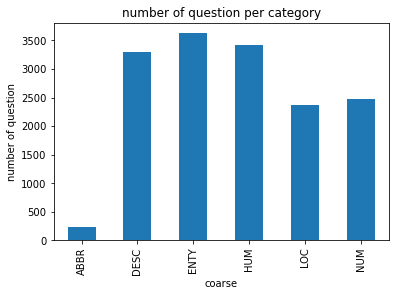

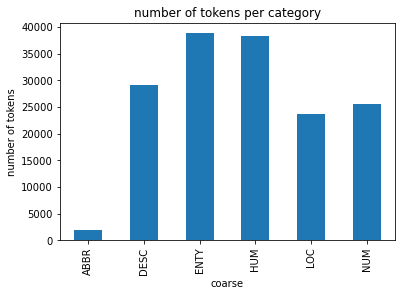

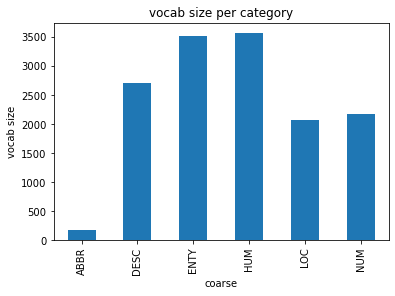

In [53]:
plot_statistics(coarse_statistics)

In [81]:
print(make_bold("coarse category statistics:"))

coarse_statistics.describe()

coarse category statistics:


,num of question,num_of_tokens,percentage,vocab size
count,6.000000,6.000000,6.000000,6.000000
mean,2575.333333,26235.333333,0.166667,2367.333333
std,1253.405548,13471.244585,0.081116,1248.654102
min,241.000000,1955.000000,0.015597,174.000000
25%,2402.000000,24175.750000,0.155449,2096.000000
50%,2892.000000,27342.500000,0.187160,2442.000000
75%,3394.000000,35945.250000,0.219648,3309.250000
max,3627.000000,38839.000000,0.234727,3567.000000


In [12]:
print(make_bold("Top 20 most frequent per coarse label"))
top_tokens_per_categoty(labels_questions,20,'coarse')

Top 20 most frequent per coarse label


,DESC,ENTY,ABBR,HUM,NUM,LOC
0,"(what, 2191)","(what, 3337)","(what, 241)","(the, 2870)","(the, 1525)","(the, 1925)"
1,"(the, 1722)","(the, 2542)","(for, 153)","(who, 1683)","(how, 1308)","(what, 1559)"
2,"(is, 1387)","(of, 1302)","(the, 140)","(what, 1499)","(many, 877)","(is, 858)"
3,"(how, 792)","(is, 1132)","(does, 137)","(of, 1084)","(what, 804)","(where, 742)"
4,"(a, 760)","(in, 913)","(stand, 117)","(was, 861)","(of, 701)","(in, 648)"
5,"(of, 693)","(a, 879)","(is, 88)","(in, 794)","(in, 661)","(of, 573)"
6,"(do, 615)","('s, 605)","(abbreviation, 52)","(is, 680)","(is, 612)","(country, 340)"
7,"(in, 366)","(,, 476)","(of, 51)","('s, 643)","(a, 571)","(city, 320)"
8,"(to, 354)","(to, 457)","(mean, 25)","(a, 449)","(are, 391)","('s, 310)"
9,"(does, 342)","(was, 385)","(in, 24)","('', 431)","(when, 380)","(,, 248)"


#### Fine category

In [44]:
fine_categories = []
for name in coarse_category_lines:
    for elem in coarse_category_lines[name]:
        fine_categories.append(elem[1])

fine_statistics=get_statistics(df,'fine',fine_categories)
fine_statistics


,num of question,num_of_tokens,percentage,vocab size
fine,,,,
abb,46,476,0.002977,61
animal,365,3738,0.023622,410
body,54,549,0.003495,82
city,376,3989,0.024333,424
code,22,237,0.001424,35
color,119,1133,0.007701,171
count,985,10660,0.063746,1155
country,425,4329,0.027505,548
cremat,595,7243,0.038506,914


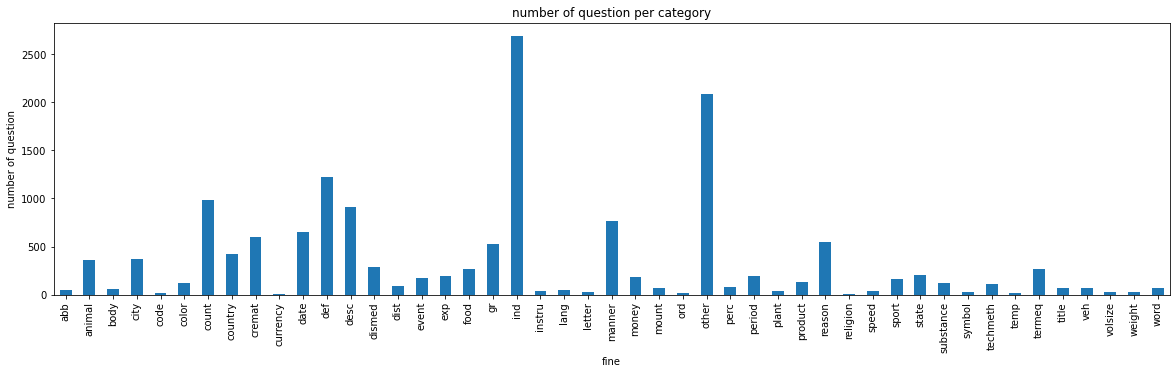

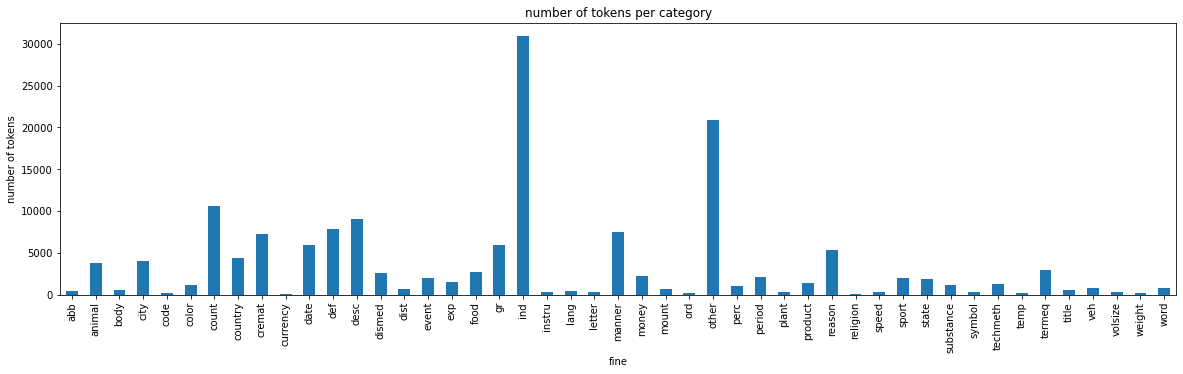

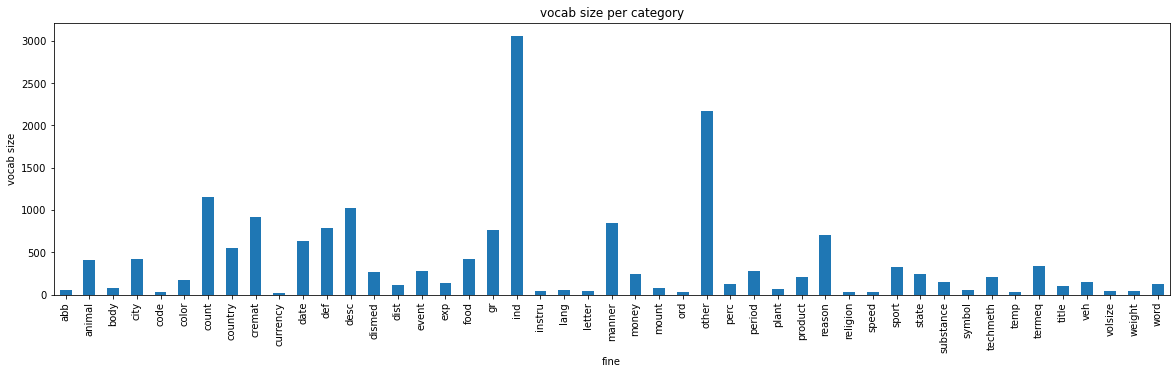

In [54]:
plot_statistics(fine_statistics,True)

In [80]:
print(make_bold("fine category statistics:"))
fine_statistics.describe()

fine category statistics:


,num of question,num_of_tokens,percentage,vocab size
count,8.000000,8.000000,8.000000,8.000000
mean,646.291540,7320.077977,11.753948,736.599316
std,890.044538,10299.640851,15.284778,1011.255361
min,6.000000,8.000000,0.000388,8.000000
25%,29.164062,176.562500,2.246099,35.257812
50%,459.067971,5030.147563,8.850664,527.411282
75%,683.847007,7756.806187,11.656129,778.259722
max,2691.000000,30968.000000,47.000000,3060.000000


In [147]:
print(make_bold("Top 20 more frequent per fine label"))
top_tokens_per_categoty(labels_questions,20,'fine')

Top 20 more frequent per fine label


,manner,cremat,animal,exp,ind,gr,title,def,date,reason,...,word,lang,perc,code,dist,temp,symbol,ord,veh,weight
0,"(how, 774)","(what, 533)","(what, 323)","(what, 195)","(the, 2412)","(the, 413)","(what, 63)","(what, 1205)","(the, 425)","(why, 290)",...,"(the, 83)","(the, 44)","(what, 82)","(what, 22)","(how, 70)","(the, 15)","(the, 40)","(the, 21)","(the, 82)","(a, 31)"
1,"(do, 377)","(the, 456)","(the, 313)","(does, 135)","(who, 1502)","(what, 384)","(the, 40)","(is, 815)","(when, 360)","(the, 270)",...,"(what, 69)","(what, 36)","(the, 80)","(number, 21)","(is, 51)","(what, 9)","(what, 31)","(what, 10)","(what, 54)","(of, 17)"
2,"(a, 258)","(in, 159)","(of, 163)","(for, 124)","(what, 1049)","(of, 160)","(is, 26)","(the, 448)","(what, 277)","(what, 244)",...,"(word, 53)","(language, 32)","(of, 73)","(the, 19)","(the, 48)","(peachy, 9)","(is, 19)","(chapter, 10)","(of, 34)","(what, 15)"
3,"(i, 227)","(a, 157)","(is, 111)","(stand, 115)","(of, 908)","(in, 150)","('s, 26)","(a, 253)","(did, 246)","(of, 114)",...,"(is, 29)","(of, 20)","(percentage, 32)","(is, 14)","(far, 31)","(oat, 9)","(for, 18)","(of, 10)","(name, 29)","(in, 13)"
4,"(the, 212)","(of, 149)","('s, 98)","(the, 70)","(was, 716)","(company, 121)","(occupation, 17)","(mean, 189)","(was, 211)","(a, 113)",...,"(english, 26)","(is, 20)","(is, 29)","(phone, 12)","(long, 23)","(muffins, 9)","(sign, 15)","(has, 10)","(was, 26)","(is, 12)"
5,"(you, 209)","(is, 122)","(in, 89)","(is, 51)","(in, 623)","(is, 115)","(of, 16)","(does, 183)","(year, 163)","(is, 113)",...,"(of, 26)","(spoken, 16)","(in, 21)","(for, 10)","(a, 23)","(temperature, 8)","(a, 14)","(bible, 6)","(in, 22)","(weigh, 11)"
6,"(can, 146)","('s, 112)","(name, 65)","(abbreviation, 25)","('s, 521)","('s, 96)","(profession, 14)","(``, 146)","(in, 134)","(in, 105)",...,"(in, 20)","(sioux, 14)","('s, 19)","(columbia, 8)","(of, 18)","(is, 7)","(symbol, 12)","(most, 6)","('s, 17)","(teaspoon, 10)"
7,"(to, 111)","(to, 106)","(animal, 65)","(mean, 25)","(is, 452)","(was, 84)","(was, 14)","('', 146)","(of, 117)","(for, 91)",...,"('s, 20)","(in, 13)","(are, 16)","(tristar, 8)","(what, 16)","(baking, 7)","(zodiacal, 7)","(verses, 6)","(ship, 15)","(matter, 10)"
8,"(of, 103)","(was, 102)","(was, 60)","(in, 24)","('', 375)","(a, 76)","(in, 14)","(of, 126)","(is, 95)","(do, 90)",...,"(for, 19)","(languages, 13)","(a, 14)","('s, 8)","(you, 13)","(for, 6)","(of, 7)","(where, 5)","(by, 13)","(black, 10)"
9,"(is, 98)","(film, 87)","(a, 60)","(,, 23)","(to, 374)","(name, 68)","(title, 12)","(are, 124)","(first, 93)","(to, 72)",...,"(a, 18)","(a, 13)","(children, 13)","(telephone, 5)","(tall, 12)","(how, 6)","(water, 5)","(does, 5)","(sank, 10)","(hole, 10)"


### Overall statistics

In [13]:
def compute_vocab_size(df):
    questions_str_list=[q for q in df['question'].str.split()]
    questions_str_list = [item for sublist in questions_str_list for item in sublist]
    questions_str_set = set(questions_str_list)
    return len(questions_str_set)

df2=add_num_of_tokens(df)
print(make_bold("num of tokens overall:"),df2['num_of_tokens'].sum())
print(make_bold("vocab size overall:"),compute_vocab_size(df))


num of tokens overall: 157412
vocab size overall: 9448


In [15]:
def get_top_overall(all_question,top):
    word_statistics = Counter(token for coarse_tag,fine_tag,question in all_question 
                     for token in question.lower().split(" "))
    return pd.DataFrame(word_statistics.most_common(top),columns=['word','count'])
get_top_overall(labels_questions,20)

In [16]:
def get_word_statistics(all_questions):
    return Counter(token for coarse_tag,fine_tag,question in all_questions 
                     for token in question.lower().split(" "))
def get_word_with_appearance(num,word_statistics):    
    words=[]
    for x in word_statistics:
        if word_statistics[x]==num:
            words.append(x)
    return len(words)

word_statistics=get_word_statistics(labels_questions)

print(make_bold('Number of words occurring 1,2,3,4 and 5 times:'))
print('1 time:',get_word_with_appearance(1,word_statistics))
print('2 time:',get_word_with_appearance(2,word_statistics))
print('3 time:',get_word_with_appearance(3,word_statistics))
print('4 time:',get_word_with_appearance(4,word_statistics))
print('5 time:',get_word_with_appearance(5,word_statistics))

Number of words occurring 1,2,3,4 and 5 times:
1 time: 1352
2 time: 1114
3 time: 1096
4 time: 1123
5 time: 1187


<a name="q1.4"></a>
<h3>Q1.4. Classifier Interface, Evaluation Metrics, Confusion Matrix</h3>

Define the Python interface (functions or class according to your preference) of a question classifier so that the 
function accuracy_score and classification_report from the sklearn.metrics module can be used.

Define a function evaluate_classifier that takes a trained classifier and reports classification results for 
coarse and fine categories.

Define a function confusion_matrix(model) which prints a confusion matrix for the coarse level categories in the same
way as in HW1 Question 3.


As most classifires, we chose our calsiisfier to have fit and predcit method .

In [17]:
class  question_classifier():
    """ this interface defines function to classify questions """
    def classes(self) -> list:
        pass
    
    def fit(self, X, y):
        " train the model with the data and correct labels "
        pass
        
    def predict(self, X):
        """ guess the label for data, after fit """
        pass

In [18]:
from sklearn import metrics
from itertools import product
from sklearn.metrics import accuracy_score
import seaborn as sns
from pandas import DataFrame

def evaluate_classifier(classifier, x_test, y_test):
    """ takes a trained classifier and reports classification results for coarse and fine categories """
    y_pred = classifier.predict(x_test)
    stats = metrics.classification_report(y_test, y_pred)
#         stats = metrics.classification_report(y_test, y_pred, digits=3, labels=classifier.classes)
    print(make_bold('accuracy:'),accuracy_score(y_pred, y_test))
    
    print(stats)
#     Only for coarse
    if classifier.classes!=None:
        print(make_bold('\n\naccuracy per tag'))
        for tag in classifier.classes:
            correct = _tag_accuracy(tag, y_pred, y_test)
            print(f'{tag}: {correct}%')
    
def _tag_accuracy(tag, y_pred, y_test):
    correct = 0
    tag_counter = 0
    for num in range(len(y_pred)):
        if y_test[num] == tag:
            tag_counter += 1
            if y_test[num] == y_pred[num]:
                correct += 1
    return 0 if tag_counter==0 else (correct/tag_counter)*100
            
    
def confusion_matrix(model, x_test, y_test):
    """ prints a confusion matrix for the coarse level categories """
    y_pred = model.predict(x_test)
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred, labels=model.classes)
    confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    cevaluate_classifieronfusion_df = DataFrame(confusion_matrix, index=model.classes, columns=model.classes)
    fig1 = plt.figure('Confusion Matrix', [8,8])
    ax1 = plt.axes()
    ax1.set_title('normalized confusion matrix')
    fig1 = sns.heatmap(cevaluate_classifieronfusion_df,annot=True,annot_kws={"size": 8})

<a name="q1.5"></a>
<h3>Q1.5 Baseline Classifier</h3>

Implement a baseline classifier for the 6 coarse labels using the heuristics described in the paper in Section 2.1
(of the form – If a query starts with Who or Whom: type Human).
<p/>

Report on the accuracy, precision, recall, and F1 measure for all the coarse labels, and provide
the confusion matrix for the 6 coarse labels.
<p/>

Analyze the errors by listing types of errors (false positives and false negatives for each of the 6 labels).


We examined the data to see which words are common for each cayegory.<br>
We've noticed that words like who-whom-whose are always in HUMAN course category. This obsservation is pretty obvious, but we did this kind of mapping also for the other coarse categories. Part of the words weren't so clear so we had to make some decisions, to which category they belong.<br>
We also saw in the data that there are words that can help us even if they are not WH-questions. So, we decided to also use them for the predictions.<br>


We chose ENTITY us the default category, so whenever we didn't know where the qestion belong, we decided it will be ENTITY.<br>
For ABBREVIATION we searched for words that contain only capital letters, if we found any word like that in the question, we tagged it us ABBREVIATION.
For LOCATION we decided to add words that indicate that the topic is location, and we did the same with NUMBER.<br>

In addition, we used the top 20 words per label for example to put 'stand' , and 'abbreveation' under ABBR, 'country','world' and 'city' ander LOC and 'name' under entity and ect. 


Another observation we had and decided to consider it in the model was the differance between unigram and bigrams. A unigram appears alone can indicate one category, but when the same word appears with another right after it, it can be more clear that is actually another category. For example, 'how' can be description, but 'how many' is clearly a number. We added that fact to our baseline model.<br><br>

In [19]:
class BaslineClassifier(question_classifier):
    classes = ['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM']
    
    map_class_unigram = {
                 'HUM': ['who', 'whom'],
                 'LOC': ['where', 'country', 'city', 'world'],
                 'NUM': ['when','date','many','year','weight','hight','length','long','speed'],
                 'DESC': ['how'],
                 'ABBR': ['stand','abbreveation'],
                 'ENTY': ['name']
                }
    
    map_class_bigram = {
                 'HUM': [],
                 'LOC': [],
                 'NUM': ['how many', 'how much', 'how long', 'how far', 'what year'],
                 'DESC': ['what is', 'what are', 'what does', 'how do'],
                 'ABBR': [],
                 'ENTY': []
                }

    def __init__(self):
        self.default_tag = 'ENTY' #this is a common tag, but does not have specific words associations
        
    def _check_tag(self, quest, words):
        return any(word in quest for word in words)
    
    def _join_bigram(self, tokens):
        return [" ".join([tokens[i], tokens[i+1]]) for i in range(len(tokens)-1)]
        
    def _set_tag(self, question):
        words_tokens = question.lower().split(" ")
        words_set = set(words_tokens)
        for tag in self.classes:
            if self._check_tag(words_set, self.map_class_unigram[tag]) or \
                self._check_tag(self._join_bigram(words_tokens), self.map_class_bigram[tag]):
                return tag
        upper = [word.isupper() for word in question.split(" ")]
        if any(upper):
                return 'ABBR'
        
        return self.default_tag
    
    def fit(self):
        pass
    
    def predict(self, X):
        tagged_quests = []
        for quest in X:
            tagged_quests.append(self._set_tag(quest))
        return tagged_quests

In [20]:
def parseLine(line):
    coarse = line.split(':')[0]
    fine = line[(line.index(':') + 1): line.index(' ')]
    question = line.split(' ')[1:]
    return [coarse, fine,' '.join(question)]

def readLines(filename):
    lines = codecs.open(filename, "r",encoding='utf-8', errors='ignore').read().strip().split('\n')
    return [parseLine(line) for line in lines]

In [21]:
def create_dataset(lines):
    X = []
    yc = []
    yf = []
    for lst in lines:
        yc.append(lst[0])
        yf.append(lst[1])
        X.append(lst[2])
    return X, yc, yf

In [22]:
def findFiles(path): return glob.glob(path)

def return_x_y(file_path):
    X_data = []
    y_coarse_labels = []
    y_fine_labels = []
    
    # run over all files in train folder
    for filename in findFiles(file_path):
        # split the ducument into lines
        lines = readLines(filename)
        X, yc, yf = create_dataset(lines)
        X_data += X
        y_coarse_labels += yc
        y_fine_labels += yf
    return X_data, y_coarse_labels, y_fine_labels

In [23]:
base = BaslineClassifier()

In [24]:
X_data, y_coarse_labels, y_fine_labels = return_x_y('data/questions/train/*.txt')

In [25]:
X_data_test, y_coarse_test, y_fine_test = return_x_y('data/questions/test/TREC_10.label.txt')

In [26]:
y_pred = base.predict(X_data_test)

Evalutaion of our baseline classifer:

In [27]:
print(make_bold("Base-line classifier evalutaion:"))
evaluate_classifier(base, X_data_test, y_coarse_test)

Base-line classifier evalutaion:
accuracy: 0.62
              precision    recall  f1-score   support

        ABBR       0.42      0.56      0.48         9
        DESC       0.49      0.96      0.65       138
        ENTY       0.52      0.50      0.51        94
         HUM       1.00      0.72      0.84        65
         LOC       0.95      0.46      0.62        81
         NUM       0.95      0.37      0.54       113

    accuracy                           0.62       500
   macro avg       0.72      0.59      0.60       500
weighted avg       0.74      0.62      0.61       500



accuracy per tag
ABBR: 55.55555555555556%
ENTY: 50.0%
DESC: 95.65217391304348%
HUM: 72.3076923076923%
LOC: 45.67901234567901%
NUM: 37.16814159292036%


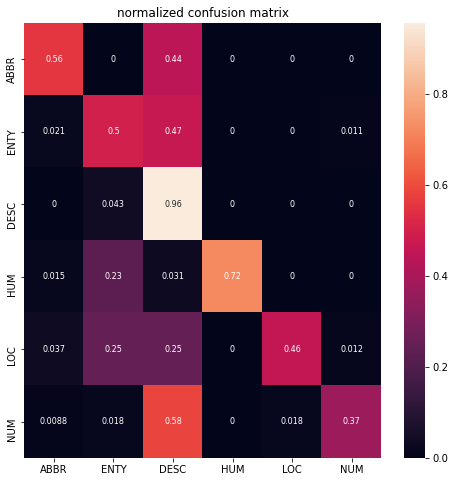

In [28]:
confusion_matrix(base, X_data_test, y_coarse_test)

We can tell that NUM was considered Desc for more that half of the time ! even more than it was classify as a NUM

In [29]:
def find_errors(x_test,y_pred,y_test):
    classes = ['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM']
    for tag in classes:
        print(make_bold(f'Errors in label {tag}:'))
        did_not_predict_tag(x_test,y_pred,y_test,tag)
        predict_tag_wrognly(x_test,y_pred,y_test,tag)
        print('\n')
    
def did_not_predict_tag(x_test,y_pred,y_test,tag):
    for num in range(len(y_pred)):
        if y_test[num] == tag and y_pred[num]!=tag:
            print(make_underline("quesion:"),f'{x_test[num]} : is labeled {y_test[num]} but was consideresd as {y_pred[num]}')
            return
def predict_tag_wrognly(x_test,y_pred,y_test,tag):
    for num in range(len(y_pred)):
        if y_pred[num] == tag and y_test[num]!=tag:
            print(make_underline("quesion:"),f'{x_test[num]} : is labeled {y_test[num]} but was consideresd as {y_pred[num]}')
            return

In [308]:
find_errors(X_data_test,y_pred,y_coarse_test)

Errors in label ABBR:
quesion: What is the abbreviation for Texas ? : is labeled ABBR but was consideresd as DESC
quesion: What river in the US is known as the Big Muddy ? : is labeled LOC but was consideresd as ABBR


Errors in label ENTY:
quesion: What is Australia 's national flower ? : is labeled ENTY but was consideresd as DESC
quesion: What county is Modesto , California in ? : is labeled LOC but was consideresd as ENTY


Errors in label DESC:
quesion: Why does the moon turn orange ? : is labeled DESC but was consideresd as ENTY
quesion: How far is it from Denver to Aspen ? : is labeled NUM but was consideresd as DESC


Errors in label HUM:
quesion: George Bush purchased a small interest in which baseball team ? : is labeled HUM but was consideresd as ENTY


Errors in label LOC:
quesion: What county is Modesto , California in ? : is labeled LOC but was consideresd as ENTY
quesion: What was the last year that the Chicago Cubs won the World Series ? : is labeled NUM but was conside

<a name="q1.6"></a>
<h3>Q1.6 Features-based Classifier</h3>

Implement a feature-based classifier for the 6 coarse labels using the types of features described in the paper Section 3.2: words, POS tags, NER tags.  
<p/>

Use the <a href="https://spacy.io/usage/spacy-101">spacy</a> library to perform pre-processing of the questions - including POS tagging and Named Entity Recognition and Noun Chunks detection.  Spacy comes with excellent pre-trained models for English and other languages.
Installing Spacy requires the following steps (see <a href="https://spacy.io/usage/spacy-101#annotations-ner">spacy documentation</a>):


In [35]:
# This installs the Spacy library (13MB)
!pip install spacy
# This downloads pre-trained models for POS tagging / NER / Noun chunks in English (34MB)
!python -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [30]:
import spacy
nlp = spacy.load('en_core_web_sm')
doc = nlp('Apple is looking at buying U.K. startup for $1 billion')
print(doc.ents)
print(doc.ents[0].label_)

(Apple, U.K., $1 billion)
ORG


Invoking the 'nlp()' function of spacy performs a set of analyses on the text, including: sentence separation, tokenization, lemmatization, parts of speech tagging, 
Noun-phrase chunking, named entity recognition and syntactic parsing.  Information about these analyses is retrieved using the spacy document properties.

As indicated in the paper, we want to extract the following information as features for the task of question classification:
<ul>
  <li>Tokens</li>
  <li>Lemmas</li>
  <li>Parts of speech tags</li>
  <li>Noun phrase chunks</li>
  <li>Named entities</li>
</ul>

Here are starting points to learn how to extract this information from the nlp analysis:

In [31]:
import spacy
nlp = spacy.load('en_core_web_sm')
doc = nlp('Apple is looking at buying U.K. startup for $1 billion')
  
# Token level features retrieved by Spacy: token, lemma, POS
for x in doc:   # Each x is a Token
    print(f"Token: {x} - Lemma: {x.lemma_} - POS: {x.pos_}")

Token: Apple - Lemma: Apple - POS: PROPN
Token: is - Lemma: be - POS: AUX
Token: looking - Lemma: look - POS: VERB
Token: at - Lemma: at - POS: ADP
Token: buying - Lemma: buy - POS: VERB
Token: U.K. - Lemma: U.K. - POS: PROPN
Token: startup - Lemma: startup - POS: NOUN
Token: for - Lemma: for - POS: ADP
Token: $ - Lemma: $ - POS: SYM
Token: 1 - Lemma: 1 - POS: NUM
Token: billion - Lemma: billion - POS: NUM


In [32]:
# Span level features retrieved by Spacy: named entities, start (0-based index), end (index just after the span), category
print(doc.ents)
for e in doc.ents: 
    print(f"{e} - {e.start} - {e.end} - {e.label_}")

(Apple, U.K., $1 billion)
Apple - 0 - 1 - ORG
U.K. - 5 - 6 - GPE
$1 billion - 8 - 11 - MONEY


In [33]:
# Span level features retrieved by Spacy: noun chunks
print(list(doc.noun_chunks))
for c in doc.noun_chunks: 
    print(f"{c.start} - {c.end} - {c.root}")

[Apple, U.K. startup]
0 - 1 - Apple
5 - 7 - startup


The paper does not explicitly indicate how to encode the features it lists and is not precise about the features named `related words` (words which are usually associated with a specific type of questions).  For example:
<ol>
<li>Word features can be encoded in different ways: noise words filtered or not, with or without lemmatization, with or without case normalization (all lower-case).  
<li>POS features can be encoded in different ways: as a bag of POS-tags, or associated with the word in a bag-of-tagged words such as 'Apple/PROPN' 
<li>Chunks can be encoded as a bag of chunk-roots 
<li>Examples of "related words" per category are provided for a few categories: <a href="https://cogcomp.seas.upenn.edu/Data/QA/QC/lists/prof">profession</a>,
    <a href="https://cogcomp.seas.upenn.edu/Data/QA/QC/lists/mount">mountains</a> and <a href="https://cogcomp.seas.upenn.edu/Data/QA/QC/lists/food">food</a>.
  You should learn the related words list from the training dataset by detecting words which have a high chi-square
value with each category.  Read in <a href="http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html">sklearn.feature_selection.chi2</a> for a discussion of how such words can be efficiently computed using scikit-learn.
</li>
</ol>


<a name="q1.6.1"></a>
<h4>Q1.6.1 Feature Extraction</h4>

Discuss a priori what are good ways to encode these features (lemma, POS, NER, chunk, related words) - provide examples that explain your intuition.
<p/>
Implement a feature extraction function that turns a question into a feature vector appropriate for the scikit-learn classifiers.
Adopt the example shown in the scikit-learn documentation: 
<a href="https://scikit-learn.org/stable/modules/feature_extraction.html#loading-features-from-dicts">loading features from dicts</a>.

#### Ways to encode words:

Word features can be encoded in different ways: noise words filtered or not, with or without lemmatization, with or without case normalization (all lower-case), we would like to find a way to encode the words and recieve the best data we can in order to train a model on it. We can ignore capital letters since the extra information they give us is not very helpfull for this kind of task. Also, there are repeated words like 'the', 'is', and so on, we don't want to give to much importance to these kind of words because they appear in the documents a lot more than the rest. So, we will take the lemma of each word, and than use tf*idf on it.

#### Ways to encode POS:
POS features can be encoded in different ways: as a bag of POS-tags, or associated with the word in a bag-of-tagged words such as 'Apple/PROPN'. We would like to reduce the connection between features, so we will encode the data to bag-of-POS.

#### Ways to encode Chunks:
Chunks can be encoded as a bag of chunk-roots. We will use bag-of-chunks-root, meaning we will take the root of each chunk and work with it as feature..

#### Ways to encode NER:
We will use bag-of-NER.

#### Ways to encode related words:
Related words can be "learned" from the training dataset by detecting words which have a high chi-square value with each class. We will extract bag of words as described in Word features, than perform a chi2 test to the words with height chi2 score. This will show us words that are very related to specific classes.
<br><br>


In [34]:
def get_lemmas(question):
    return " ".join([word.lemma_ for word in question])

def get_nchunks(question):
    return " ".join([chunk.root.text for chunk in question.noun_chunks])

def get_ner(question):
    return " ".join([ent.label_ for ent in question.ents])

def get_pos(question):
    return " ".join([word.pos_ for word in question])


In [35]:
def make_features_dict(data):
    featues_dict = {
        'lemma': [], 
        'noun-chunks': [], 
        'name-entities': [],
        'pos': []}
    # create spacy nlp object from list
    questions = create_features_data(data)

    for index, question in enumerate(questions):
        featues_dict['lemma'].append(get_lemmas(question)) 
        featues_dict['noun-chunks'].append(get_nchunks(question))
        featues_dict['name-entities'].append(get_ner(question))
        featues_dict['pos'].append(get_pos(question))

    return featues_dict 

In [36]:
from scipy.sparse import  hstack
from sklearn.feature_extraction.text import CountVectorizer
def extract_features(train_data,test_data):
#     extract train features
    dictf=make_features_dict(train_data)
    count_vec_ner = CountVectorizer(ngram_range=(1, 2)).fit(dictf['name-entities'])
    ner_ft = count_vec_ner.transform(dictf['name-entities'])
    count_vec_lemma = CountVectorizer(ngram_range=(1, 2)).fit(dictf['lemma'])
    lemma_ft = count_vec_lemma.transform(dictf['lemma'])
    count_vec_chunk = CountVectorizer(ngram_range=(1, 2)).fit(dictf['noun-chunks'])
    chunk_ft = count_vec_chunk.transform(dictf['noun-chunks'])
    count_vec_pos = CountVectorizer(ngram_range=(1, 2)).fit(dictf['pos'])
    pos_ft = count_vec_pos.transform(dictf['pos'])
    train_features = hstack([ner_ft, lemma_ft, chunk_ft,pos_ft])
    
#     extract test features
    dictf_test=make_features_dict(test_data)
    ner_test_ft = count_vec_ner.transform(dictf_test['name-entities'])
    lemma_test_ft = count_vec_lemma.transform(dictf_test['lemma'])
    chunk_test_ft = count_vec_chunk.transform(dictf_test['noun-chunks'])
    post_test_ft = count_vec_pos.transform(dictf_test['pos'])
    test_features =hstack([ner_test_ft, lemma_test_ft, chunk_test_ft,post_test_ft])
    
    return train_features.tocsr(),test_features.tocsr()



<a name="q1.6.2"></a>
<h4>Q1.6.2 Train Models</h4>

Train scikit-learn based classifiers for:
<ol>
<li>Coarse labels
<li>All labels as a flat classifier
<li>A hierarchical classifier which predicts the fine-grained labels given the coarse label as proposed in the paper.  Implement this as a two-step procedure - run the coarse-label classifier, then a second level classifier which takes the prediction of the first classifier as input (one finer classifier per coarse category).
</ol>

For each of the three classifiers, report:
<ol>
<li>Accuracy, Precision, Recall, F-measure per label and confusion matrix.
<li>Provide examples of prediction errors (positive and negative).
<li>Discuss the most ambiguous label pairs (identified in the confusion matrix) and discuss whether the features you have used provide sufficient information to disambiguate the cases.
</ol>

You should experiment with different classifiers from those illustrated in the
<a href="https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html">
Classification of text documents using sparse features</a> example.
<p/>

In [42]:
def create_features_data(X):
    lst = []
    for x in X:
        lst.append(nlp(x))
    return tuple(lst)

In [60]:
class coarseLabelClassifier(question_classifier):
    def __init__(self, clf,classes):
        self.classes=classes
        self.clf = clf

    def fit(self, X, y):
        self.clf.fit(X, y)
            
    def predict(self, X):
        return self.clf.predict(X)

In [58]:
class fineLabelClassifier(question_classifier):   
    def __init__(self, clf):
        self.clf = clf
        
    def fit(self, X, y):
        self.clf.fit(X, y)
            
    def predict(self, X):
        self.clf.predict(X)
        

In [98]:
def calssify(train_features,y_train,test_features,y_test,quest_clf,name='classier'):
    quest_clf.fit(train_features, y_train)
    prediction=quest_clf.predict(test_features)
    stats = metrics.precision_score(y_test, prediction,zero_division=1,average='micro')
    print(make_bold(f'{name}:\n'),f'acc:{stats*100}%')
    return stats 

In [101]:
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import operator

classifiers = [(RidgeClassifier(tol=1e-2, solver="sparse_cg"), "Ridge Classifier"),
    (Perceptron(max_iter=50), "Perceptron"),
    (PassiveAggressiveClassifier(max_iter=50),
     "Passive-Aggressive"),
    (KNeighborsClassifier(n_neighbors=10), "kNN"),
    (RandomForestClassifier(), "Random forest")]

def find_best_classifier(X_train,y_train,X_test,y_test,clf_type):
    results={}
    train_features,test_features=extract_features(X_train,X_test)
    for clf,name in classifiers:
        if clf_type=='fine':
            fine_categories=pd.unique(df['fine'])
            print(make_bold("Choosing best fine classifier"))
            quest_clf=coarseLabelClassifier(clf,fine_categories)  
            results[name]=calssify(train_features,y_train,test_features,y_test,quest_clf,name)
        else: #coarse
            print(make_bold("Choosing best Coarse classifier"))
            coarse_categories = ["ABBREVIATION", "ENTITY", "DESCRIPTION", "HUMAN", "LOCATION", "NUMERIC VALUE"]
            quest_clf=coarseLabelClassifier(clf,coarse_categories)
            results[name]=calssify(train_features,y_train,test_features,y_test,quest_clf,name)
    print(results)
    return max(results.items(), key=operator.itemgetter(1))[0]
        

In [75]:
best_coarse_clf=find_best_classifier(X_data, y_coarse_labels,X_data_test, y_coarse_test,'coarse')

Choosing best Coarse classifier
Ridge Classifier:
 acc:90.2%
Choosing best Coarse classifier
Perceptron:
 acc:89.8%
Choosing best Coarse classifier
Passive-Aggressive:
 acc:90.4%
Choosing best Coarse classifier
kNN:
 acc:74.6%
Choosing best Coarse classifier
Random forest:
 acc:86.8%
{'Ridge Classifier': 0.902, 'Perceptron': 0.898, 'Passive-Aggressive': 0.904, 'kNN': 0.746, 'Random forest': 0.868}


In [107]:
best_coarse_clf

'Passive-Aggressive'

In [102]:
best_fine_clf=find_best_classifier(X_data, y_fine_labels,X_data_test, y_fine_test,'fine')

Choosing best fine classifier
Ridge Classifier:
 acc:83.6%
Choosing best fine classifier
Perceptron:
 acc:81.39999999999999%
Choosing best fine classifier
Passive-Aggressive:
 acc:86.2%
Choosing best fine classifier
kNN:
 acc:63.6%
Choosing best fine classifier
Random forest:
 acc:77.0%
{'Ridge Classifier': 0.836, 'Perceptron': 0.814, 'Passive-Aggressive': 0.862, 'kNN': 0.636, 'Random forest': 0.77}


In [108]:
best_fine_clf

'Passive-Aggressive'

In [127]:
def get_calssifier(name):
    for clf,clf_name in classifiers:
        if name == clf_name:
            return clf
 
    print( "clf doesn't exist")
    return None

In [219]:
def hierarchical_classification(X_data, y_coarse_labels,y_fine_labels,X_data_test,y_coarse_test,y_fine_test
                                ,best_clf_coarse_name,best_clf_fine_name):
    fine_categories=pd.unique(df['fine'])
    coarse_categories = ["ABBREVIATION", "ENTITY", "DESCRIPTION", "HUMAN", "LOCATION", "NUMERIC VALUE"]
    best_clf_coarse= coarseLabelClassifier(get_calssifier(best_clf_coarse_name),coarse_categories)
    best_clf_fine= coarseLabelClassifier(get_calssifier(best_clf_fine_name),fine_categories)
    train_f,test_f=extract_features(X_data,X_data_test)    
    y_pred_coarse= calssify(train_f,y_coarse_labels,test_f,y_coarse_test,best_clf_coarse,'coarse classier')
    new_train_data =np.hstack([X_data,y_coarse_labels])
    new_test_data =np.hstack([X_data_test,y_pred_coarse])
    y_pred_fine= calssify(new_train_data,y_fine_labels,new_test_data,y_fine_test,best_clf_fine,'fine classier')

In [217]:
hierarchical_classification(X_data, y_coarse_labels,y_fine_labels,X_data_test,y_coarse_test,y_fine_test
                                ,best_coarse_clf,best_fine_clf)

coarse classier:
 acc:90.8%
fine classier:
 acc:85.8%


<a name="q1.7"></a>
<h3>Q1.7 Optional</h3>

1.7.1 Analyze which of the features are most helpful for this task among lemma, POS, NER, Chunks and Related Words.
(This analysis is called <a href="https://en.wikipedia.org/wiki/Ablation_(artificial_intelligence)#:~:text=In%20artificial%20intelligence%20(AI)%2C,component%20to%20the%20overall%20system.">ablation analysis</a>).
<p/>

1.7.2 The dataset is quite small (5,500 questions in the training dataset for 50 labels).
How would you determine whether your model overfits on this data? 

<hr/>
<a name="q2"></a>
<h2>Q2. Document Classification</h2>

<a name="q2.1"></a>
<h3>Q2.1. Reuters Dataset</h3>

Execute the notebook tutorial of Scikit-Learn on text classification: 
<a href="http://scikit-learn.org/dev/auto_examples/applications/plot_out_of_core_classification.html#example-applications-plot-out-of-core-classification-py">out of core classification</a>.
<p/>

In [222]:
import nltk
nltk.download('reuters')
from nltk.corpus import reuters


[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\Shani\AppData\Roaming\nltk_data...


<a name="q2.1.1"></a>
<h4>Q2.1.1 Descriptive Statistics</h4> 

Explore how many documents are in the dataset, how many categories, how many documents per categories, provide mean and standard deviation, min and max. (use the pandas library to explore the dataset, use the dataframe.describe() method.)

Explore how many characters and words are present in the documents of the dataset.

In [227]:
docs = reuters.fileids()
all_categories = reuters.categories()
fd = nltk.FreqDist(reuters.words())
print(make_bold("number of documents in the reuters dataset is :"),len(docs))
print(make_bold(f"Reuters has has {len(all_categories)} cateries"))
print(make_bold('numbers of word in the documents:'),len(fd))
chars = sum([len(x) for x in fd])
print(make_bold('number of characters in the documents:'),f'{chars}')


number of documents in the reuters dataset is : 10788
Reuters has has 90 cateries
numbers of word in the documents: 41600
number of characters in the documents: 282805


In [208]:
print('Rueters Category')
pd.DataFrame(all_categories)

Reuters has 90 categories, which are:

['acq', 'alum', 'barley', 'bop', 'carcass', 'castor-oil', 'cocoa', 'coconut', 'coconut-oil', 'coffee', 'copper', 'copra-cake', 'corn', 'cotton', 'cotton-oil', 'cpi', 'cpu', 'crude', 'dfl', 'dlr', 'dmk', 'earn', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'groundnut', 'groundnut-oil', 'heat', 'hog', 'housing', 'income', 'instal-debt', 'interest', 'ipi', 'iron-steel', 'jet', 'jobs', 'l-cattle', 'lead', 'lei', 'lin-oil', 'livestock', 'lumber', 'meal-feed', 'money-fx', 'money-supply', 'naphtha', 'nat-gas', 'nickel', 'nkr', 'nzdlr', 'oat', 'oilseed', 'orange', 'palladium', 'palm-oil', 'palmkernel', 'pet-chem', 'platinum', 'potato', 'propane', 'rand', 'rape-oil', 'rapeseed', 'reserves', 'retail', 'rice', 'rubber', 'rye', 'ship', 'silver', 'sorghum', 'soy-meal', 'soy-oil', 'soybean', 'strategic-metal', 'sugar', 'sun-meal', 'sun-oil', 'sunseed', 'tea', 'tin', 'trade', 'veg-oil', 'wheat', 'wpi', 'yen', 'zinc']


In [228]:
# create counter to summarize
categories = []
file_count = []

# count each tag's number of documents
for i in reuters.categories():
    file_count.append(len(reuters.paras(categories=[i])))
    categories.append(i)
    
# create a dataframe out of the counts
df = pd.DataFrame(
    {'categories': categories, "file_count": file_count})
df

,categories,file_count
0,acq,2661
1,alum,62
2,barley,58
3,bop,120
4,carcass,69
...,...,...
85,veg-oil,128
86,wheat,304
87,wpi,32
88,yen,70


Text(0.5, 0.98, 'File count per category')

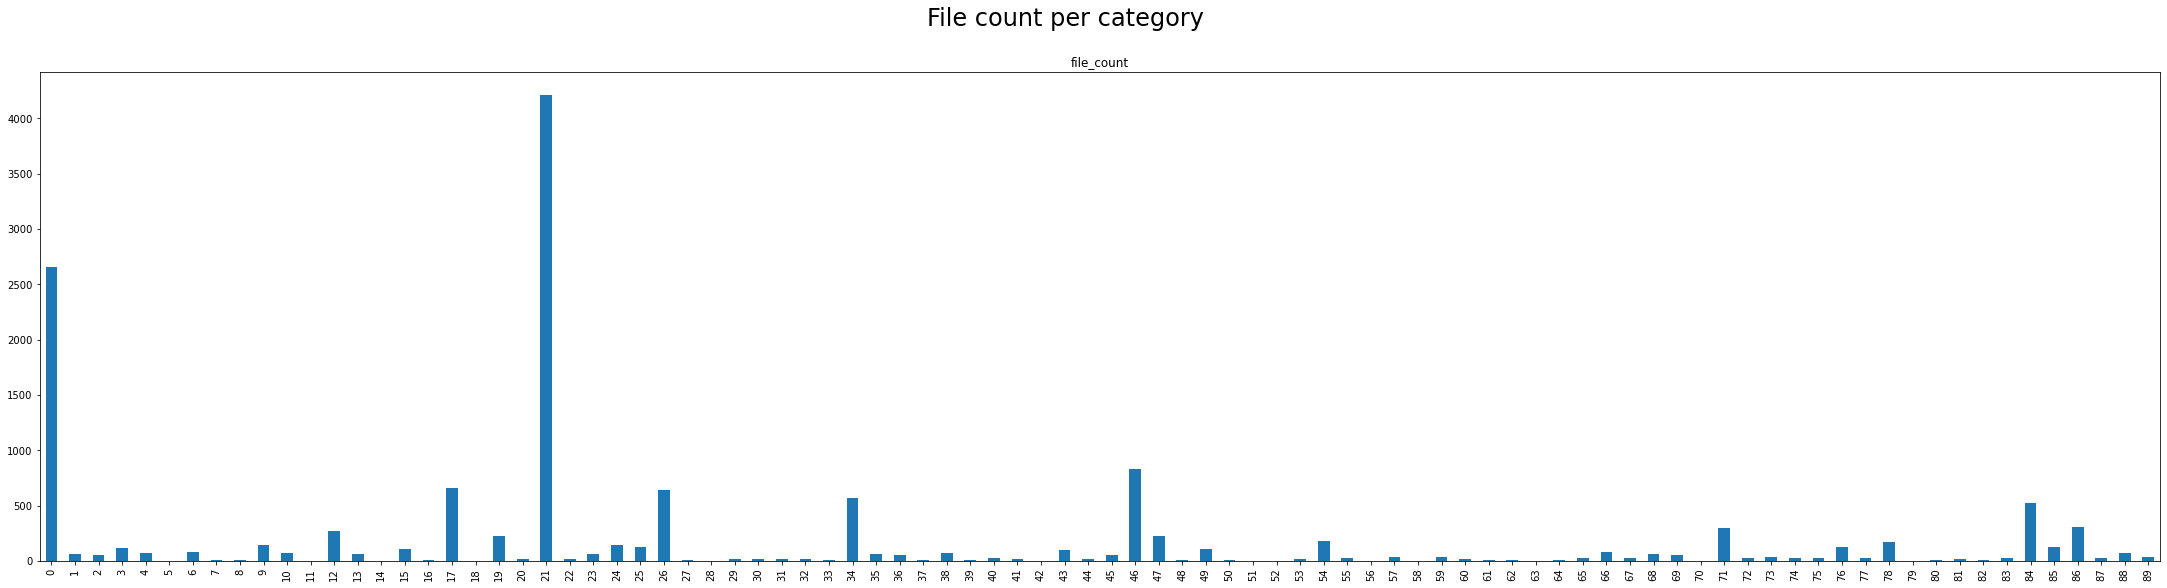

In [229]:
df['file_count'].plot.bar(subplots=True, figsize=(38, 9))
plt.suptitle("File count per category", fontsize=24)

In [211]:
# get statistics on all documents in all categories together
df.describe()

,file_count
count,90.000000
mean,162.888889
std,532.185201
min,2.000000
25%,8.000000
50%,30.000000
75%,97.250000
max,4211.000000


<a name="q2.1.2"></a>
<h4>Q2.1.2 Partial-fit classifiers</h4> 

Explain informally what are the classifiers that support the "partial-fit" method discussed in the code.

********************************************

Partial_fit allows the model to learn incrementally from a mini-batch of instances. 
The classifiers that support the partial-fit method, can perform online machine learning. meaning - they can learn the function  𝑓  without seeing the entire dataset, but only seeing parts of it sequentially. This kind classifiers are useful when dealing with large datasets that cannot fit into the main memory.

The classifiers that support the partial_fit method are:
- SGDClassifier - implements regularized linear models with stochastic gradient descent learning, the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule. 
- PassiveAggressiveClassifier - Passive Aggressive Classifier, family of algorithms for large-scale learning, include a regularization parameter.
- Perceptron - suitable for large scale learning. equivalent to SGDClassifier(loss=”perceptron”, eta0=1, learning_rate=”constant”, penalty=None).
- BernoulliNB - Naive Bayes classifier for multivariate Bernoulli models,  suitable for discrete data. Works with occurrence counts, designed for binary/boolean features.
- MultinomialNB - Naive Bayes classifier for multinomial modelsת suitable for classification with discrete features. Requires integer feature counts.

<a name="q2.1.3"></a>
<h4>Q2.1.3 Hashing Vectorizer</h4> 

Explain what is the hashing vectorizer used in this tutorial.  Why is it important to use this vectorizer to achieve "streaming classification"?

*****************************

Hashing Vectorizer convert a collection of text documents to a matrix of token occurrences, possibly normalized as token frequencies (if norm=’l1’) or projected on the euclidean unit sphere (if norm=’l2’). Designed to be as memory efficient as possible. Instead of storing the tokens as strings, the vectorizer applies the hashing trick to encode them as numerical indexes.

In order to guarantee that features space remains the same over time, we can leverag a HashingVectorizer that will project each example into the same feature space. This is useful because new words may appear in each batch.

Hashing vectorizer uses an hash function to find the index in the vector each word would map to. This is useful, since in partial-fit, we don't see the entire dataset before the learning, so we can't map each word to an integer (We don't fit the vectorizer). Also, we don't need to keep the entire vocabulary as a dictionary in memory, which could be useful for a large vocabulary.

Stream classification is a variant of incremental learning of classifiers that has to satisfy requirements specific for massive streams of data: restrictive processing time, limited memory, and one scan of incoming examples.

It is important to use hashing vectorizer to achieve "streaming classification" because it guarantee that the input space of the estimator has always the same dimensionality. Amount of memory is bounded to the mini batch size.
with hashing vectorizer the streams of data are hashed with a function to term frequency counts in each document, so we could work with it and get the results we want, and to save memory space (which is limited). 


<a name="q2.2"></a>
<h3>Q2.2. BBC News Dataset</h3>

The <a href="https://www.kaggle.com/c/learn-ai-bbc/data">Kaggle BBC News</a> dataset is a document dataset to test document classification.
It contains 1,500 training documents (news stories from the BBC News) and 700 test documents. Documents are classified into 5 categories: sports, tech, business, 
entertainment, politics.  Text is encoded in the following format: all lower case, quotes are removed and separated, non period punctuations are removed.
For example:
<pre>
lifestyle  governs mobile choice  faster  better or funkier hardware alone is not going to help phone firms sell more handsets
research suggests.  instead  phone firms keen to get more out of their customers should not just be pushing the technology 
for its own sake. consumers are far more interested in how handsets fit in with their lifestyle than they are in screen size  
onboard memory or the chip inside  shows an in-depth study by handset maker ericsson.  
historically in the industry there has been too much focus on using technology   
said dr michael bjorn  senior advisor on mobile media at ericsson s consumer and enterprise lab.
</pre>

Download the data <a href="bbcnews.zip">bbcnews.zip</a> and place it in ../data.

<a name="q2.2.1"></a>
<h4>Q2.2.1 Dataset Exploration</h4>

Explore how many documents are in the dataset, how many categories, how many documents per categories, provide mean and standard deviation, min and max. 

In [215]:
# get the data 
df = pd.read_csv('data/bbcnews/BBC News Train.csv')
# count rows
print(f'there are {len(df)} documents in the TRAIN dataset')

# get categories data
cat = df['Category'].value_counts()

# count categories
print(f'\nnumber of categories: {len(cat)}')

# print categories documents num
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_id_df
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
id_to_category
df.sample(5, random_state=0)
df.groupby('Category').category_id.count()

there are 1490 documents in the TRAIN dataset

number of categories: 5


Category
business         336
entertainment    273
politics         274
sport            346
tech             261
Name: category_id, dtype: int64

In [ ]:
cat.plot()
plt.suptitle("BBC news documents distribution", fontsize=16)

In [216]:
# get statistics
cat.describe()

count      5.000000
mean     298.000000
std       39.742924
min      261.000000
25%      273.000000
50%      274.000000
75%      336.000000
max      346.000000
Name: Category, dtype: float64

<a name="q2.2.2"></a>
<h4>Q2.2.2 Features Extraction</h4>

Select appropriate features for document classification and implement a scikit-learn vectorizer for this dataset.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [30]:
# calculate a tf-idf vector for each of our documents
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Text).toarray()

labels = df.category_id
# show features tfidf shape
features.shape

(1490, 9927)

In [12]:
from sklearn.feature_selection import chi2

N = 3

# find the terms are the most correlated with each of the categories
for newstype, category_id in sorted(category_to_id.items()):
    # extract features by Chi-square distribution
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    # get unigram and bifram from documents
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(newstype))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'business':
  . Most correlated unigrams:
       . growth
       . bank
       . shares
  . Most correlated bigrams:
       . stock market
       . economic growth
       . analysts said
# 'entertainment':
  . Most correlated unigrams:
       . singer
       . actor
       . film
  . Most correlated bigrams:
       . won best
       . los angeles
       . box office
# 'politics':
  . Most correlated unigrams:
       . blair
       . election
       . labour
  . Most correlated bigrams:
       . prime minister
       . tony blair
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . match
       . coach
       . cup
  . Most correlated bigrams:
       . grand slam
       . champions league
       . australian open
# 'tech':
  . Most correlated unigrams:
       . technology
       . software
       . users
  . Most correlated bigrams:
       . anti virus
       . mobile phones
       . mobile phone


In [13]:
features_chi2

(array([0.13345481, 0.01563765, 0.00108776, ..., 0.00812363, 0.15434356,
        0.120306  ]),
 array([0.71487652, 0.9004835 , 0.97368962, ..., 0.92818297, 0.69441858,
        0.72870284]))

<a name="q2.2.3"></a>
<h4>Q2.2.3 Model Training and Evaluation</h4>

Implement a classifier for this dataset.  
<p/>
Report performance, confusion matrix and analyze errors.
<p/>

In order to run the test data, you will need to register to Kaggle and use their submission system.
To avoid the complexity of using the Kaggle submission system, split the train data into 80% training / 20% test.  
<p/>

You can see examples solving this task with good usage of scikit-learn APIs in <a href="https://www.kaggle.com/c/learn-ai-bbc/leaderboard">the Kaggle leaderboard</a>.
In particular, <a href="https://www.kaggle.com/aryankaul31/aryan-bbc-news-classification">aryan-bbc-news-classification</a> demonstrates data exploration for 
classification using pandas, tf-idf features, TSNE visualization for feature vectors, and chi-square correlation between features and labels. 

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
from IPython.display import display


In [40]:
#Split Data 
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, 
                                                                                 test_size=0.2, random_state=0)
# create a classification model
model = LogisticRegression(random_state=0)
# train the model
model.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [44]:
# Make Predictions
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

Text(0.5, 15.0, 'Predicted')

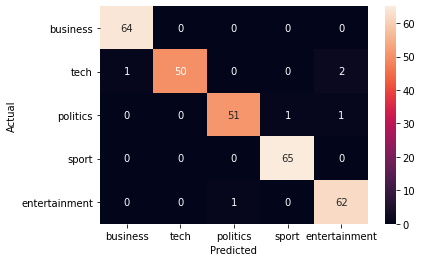

In [69]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [63]:
acc = accuracy_score(y_test,y_pred)
print("Accuracy: ",acc)

Accuracy:  0.9798657718120806


In [75]:
# examples text to get prediction on 
text = "worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy."

In [80]:
# transform a count matrix to a normalized tf or tf-idf representation
test_features = tfidf.transform([text])
# get prediction on the data
prediction = model.predict(test_features)
id_to_category = {0: 'business', 1: 'tech', 2: 'politics', 3: 'sport', 4: 'entertainment'}
for i in range(len(prediction)):
    print(id_to_category[prediction[i]])

business


This looks good, we predicted business and it is the correct category. So the model learned as we wanted it to

In [82]:
# we want to analyze the errors of the mode
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
    # printwhere there was a misprediction at least twice
        if predicted != actual and conf_mat[actual, predicted] >= 2:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]]['Text'])
            print('')

'tech' predicted as 'entertainment' : 2 examples.


1091    ultimate game  award for doom 3 sci-fi shooter...
1115    ultimate game  award for doom 3 sci-fi shooter...
Name: Text, dtype: object

<hr/>
<a name="q3"></a>
<h2>Q3. Named Entity Recognition</h2>

<h3>Named Entity Recognition</h3>

The task of Named Entity Recognition (NER) involves the recognition of names of persons, locations, organizations, dates in free text.
As we have seen above, Spacy includes a very good NER model as part of its library.  In this question, we will study how to implement 
such a model.

The following sentence is tagged with sub-sequences indicating PER (for persons), LOC (for location) and ORG (for organization):
<pre>
Wolff, currently a journalist in Argentina, played with Del Bosque in the final years of the seventies in Real Madrid.

[PER Wolff ] , currently a journalist in [LOC Argentina ] , played with [PER Del Bosque ] in the final years of the seventies in 
[ORG Real Madrid ] .
</pre>

NER involves 2 sub-tasks: identifying the boundaries of such expressions (the open and close brackets) and labelling the expressions
(with tags such as PER, LOC or ORG).  This sequence labelling task is reduced into a classification task, using the BIO encoding of the data:
<pre>
        Wolff B-PER
            , O
    currently O
            a O
   journalist O
           in O
    Argentina B-LOC
            , O
       played O
         with O
          Del B-PER
       Bosque I-PER
           in O
          the O
        final O
        years O
           of O
          the O
    seventies O
           in O
         Real B-ORG
       Madrid I-ORG
            . O
</pre>


<h3>Dataset</h3>

The dataset we will use for this question is derived from the CoNLL 2002 shared task - which is about NER in Spanish and Dutch.
The dataset is included in the NLTK distribution.  Explanations on the dataset are provided in the 
<a href='https://www.clips.uantwerpen.be/conll2002/ner/'>CoNLL 2002</a> page.
<p/>

To access the data in Python, do:

In [2]:
import nltk
nltk.download('conll2002')

[nltk_data] Downloading package conll2002 to
[nltk_data]     C:\Users\yaelj\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!


True

In [3]:
from nltk.corpus import conll2002

etr = conll2002.chunked_sents('esp.train') # In Spanish
eta = conll2002.chunked_sents('esp.testa') # In Spanish
etb = conll2002.chunked_sents('esp.testb') # In Spanish

dtr = conll2002.chunked_sents('ned.train') # In Dutch
dta = conll2002.chunked_sents('ned.testa') # In Dutch
dtb = conll2002.chunked_sents('ned.testb') # In Dutch

The data consists of three files per language (Spanish and Dutch): one training file and two test files testa and testb. 
The first test file is to be used in the development phase for finding good parameters for the learning system. 
The second test file will be used for the final evaluation.

<a name="q3.1"></a>
<h3>Q3.1 Features</h3>

Your task consists of:
<ol>
<li>Choosing good features for encoding the problem.
<li>Encode your training dataset.
<li>Run a classifier over the training dataset.
<li>Train and test the model.
<li>Perform error analysis and fine tune model parameters on the testa part of the datasets.
<li>Perform evaluation over the testb part of the dataset, reporting on accuracy, per label precision, per label recall and per label F-measure, and confusion matrix.
</ol>
<p/>

Here is a list of features that have been found appropriate for NER in previous work:
<ol>
<li>The word form (the string as it appears in the sentence)
<li>The POS of the word (which is provided in the dataset)
<li>ORT - a feature that captures the orthographic (letter) structure of the word.  It can have any of the following values: 
    number, contains-digit, contains-hyphen, capitalized, all-capitals, URL, punctuation, regular. 
<li>prefix1: first letter of the word
<li>prefix2: first two letters of the word
<li>prefix3: first three letters of the word
<li>suffix1: last letter of the word
<li>suffix2: last two letters of the word
<li>suffix3: last three letters of the word
</ol>

<p/>

For example, given the following toy training data, the encoding of the features would be:
<pre>
        Wolff NP  B-PER
            , ,   O
    currently RB  O
            a AT  O
   journalist NN  O
           in IN  O
    Argentina NP  B-LOC
            , ,   O
       played VBD O
         with IN  O
          Del NP  B-PER
       Bosque NP  I-PER
           in IN  O
          the AT  O
        final JJ  O
        years NNS O
           of IN  O
          the AT  O
    seventies NNS O
           in IN  O
         Real NP  B-ORG
       Madrid NP  I-ORG
            . .   O

<u>Classes</u>
1 B-PER
2 I-PER
3 B-LOC
4 I-LOC
5 B-ORG
6 I-ORG
7 O

<u>Feature WORD-FORM:</u>
1 Wolff
2 ,
3 currently
4 a
5 journalist
6 in
7 Argentina
8 played
9 with
10 Del
11 Bosque
12 the
13 final
14 years
15 of
16 seventies
17 Real
18 Madrid
19 .

<u>Feature POS</u>
20 NP
21 ,
22 RB
23 AT
24 NN
25 VBD
26 JJ
27 NNS
28 .

<u>Feature ORT</u>
29 number
30 contains-digit
31 contains-hyphen
32 capitalized
33 all-capitals
34 URL
35 punctuation
36 regular

<u>Feature Prefix1</u>
37 W
38 ,
39 c
40 a
41 j
42 i
43 A
44 p
45 w
46 D
47 B
48 t
49 f
50 y
51 o
52 s
53 .
</pre>

Given this encoding, we can compute the vector representing the first word "Wolff NP B-PER" as:
<pre>
# Class: B-PER=1
# Word-form: Wolff=1
# POS: NP=20
# ORT: Capitalized=32
# prefix1: W=37
1 1:1 20:1 32:1 37:1
</pre>

When you encode the test dataset, some of the word-forms will be unknown (not seen in the training dataset).
You should, therefore, plan for a special value for each feature of type "unknown" when this is expected.
<p/>

Instead of writing the code as explained above, use the Scikit-learn vectorizer and pipeline library.
General information on feature extraction for text data in Scikit-Learn is 
in <a href="https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction">the Scikit-Learn documentation</a>.
Refer to the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html">DictVectorizer</a> for this specific task.
<a href="https://scikit-learn.org/stable/auto_examples/text/plot_hashing_vs_dict_vectorizer.html">Hashing vs. DictVectorizer</a>
also provides useful background.

<a name="q3.1.1"></a>
<h4>Q3.1.1 Feature Extraction</h4>

Start from the following example notebook
<a href="http://nbviewer.ipython.org/github/tpeng/python-crfsuite/blob/master/examples/CoNLL%202002.ipynb">CoNLL 2002 Classification with CRF</a>.
You do not need to install Python-CRFSuite - just take this notebook as a starting point to explore the dataset and ways to encode features.
(This notebook also gives you an indication of the level of result you can expect to obtain.)

First, we will prepare the data for later use, train, testa, testb for both languages:

In [220]:
%%time
train_esp_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_esp_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))
testa_esp_sents = list(nltk.corpus.conll2002.iob_sents('esp.testa'))

Wall time: 3.44 s


In [221]:
%%time
train_ned_sents = list(nltk.corpus.conll2002.iob_sents('ned.train'))
test_ned_sents = list(nltk.corpus.conll2002.iob_sents('ned.testb'))
testa_ned_sents = list(nltk.corpus.conll2002.iob_sents('ned.testa'))

Wall time: 2.74 s


Let's take a look at the data representation, so we'll know what we are going to work with:

In [6]:
train_esp_sents[0]

[('Melbourne', 'NP', 'B-LOC'),
 ('(', 'Fpa', 'O'),
 ('Australia', 'NP', 'B-LOC'),
 (')', 'Fpt', 'O'),
 (',', 'Fc', 'O'),
 ('25', 'Z', 'O'),
 ('may', 'NC', 'O'),
 ('(', 'Fpa', 'O'),
 ('EFE', 'NC', 'B-ORG'),
 (')', 'Fpt', 'O'),
 ('.', 'Fp', 'O')]

In [222]:
def special_chars(word):
    # check if a given word contain digits or '-' or '_'
    for char in word:
        if char.isdigit():
            return True
        elif char == '-' or char == '_':
            return True
        else:
            pass
    return False

In [223]:
def extract_features(sent, index):
    # extract from a given sentence the features, as we thought are useful
    word = sent[index][0]
    postag = sent[index][1]
    spec = special_chars(word)
    return {'word': word, 'postag': postag, 'isNumber': word.isnumeric(), 'specialChars': spec, 'allCapital': word.isupper(),
           'capitalized': word[0].isupper(), 'prefix': word[:2], 'suffix2': word[-2:], 'suffix3': word[-3:]}
    

In [224]:
# return features extracted per word
def show_data(sent):
    return [extract_features(sent, i) for i in range(len(sent))]

In [225]:
show_data(train_esp_sents[0])[0]

{'word': 'Melbourne',
 'postag': 'NP',
 'isNumber': False,
 'specialChars': False,
 'allCapital': False,
 'capitalized': True,
 'prefix': 'Me',
 'suffix2': 'ne',
 'suffix3': 'rne'}

So, for each word, we get this map containing intresting features on it.

In [227]:
def get_class(sent, i):
    # get  sentence class tagging
    return sent[i][2]

def dicts_list(data):
    # extract features for the entire dataset
    return sum([[extract_features(sent, i) for i in range(len(sent))] for sent in data],[])

def get_all_classes(data):
    # get class for all the dataset
    return sum([[get_class(sent, i) for i in range(len(sent))] for sent in data],[])

In [12]:
len(dicts_list(train_esp_sents))

264715

In [13]:
get_all_classes(train_esp_sents)[0]

'B-LOC'

Again, we will prepare the dataset, but now for the features we included

In [235]:
X_esp_train = dicts_list(train_esp_sents)
y_esp_train = get_all_classes(train_esp_sents)

X_esp_test = dicts_list(test_esp_sents)
y_esp_test = get_all_classes(test_esp_sents)

X_esp_testa = dicts_list(testa_esp_sents)
y_esp_testa = get_all_classes(testa_esp_sents)

In [236]:
X_ned_train = dicts_list(train_ned_sents)
y_ned_train = get_all_classes(train_ned_sents)

X_ned_test = dicts_list(test_ned_sents)
y_ned_test = get_all_classes(test_ned_sents)

X_ned_testa = dicts_list(testa_ned_sents)
y_ned_testa = get_all_classes(testa_ned_sents)

<a name="q3.1.2"></a>
<h4>Q3.1.2 Model Training</h4>

Train the model using a logistic regression classifier and experiment with better features - 
looking at the tags of the previous word, the previous word and the following word (add padding words in the vectorizer).

We first begin to train the model with the features we extracted from the data, we will see if those features were a good choice by the accuracy of the model after we train it.

In [243]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer

def create_pipeline():
    pipeline = Pipeline([
        ('vectorizer', DictVectorizer(sparse=True)),
        ('classifier', LogisticRegression(solver='sag', max_iter=1000))
    ])
    # this is the pipeline we will train
    return pipeline

# create the pipeline to use
pipeline = create_pipeline()

In [244]:
pipeline.fit(X_esp_train, y_esp_train)

Pipeline(steps=[('vectorizer', DictVectorizer()),
                ('classifier',
                 LogisticRegression(max_iter=1000, solver='sag'))])

In [245]:
predictions_esp = pipeline.predict(X_esp_test)
predictions_esp

array(['B-LOC', 'I-LOC', 'O', ..., 'O', 'O', 'O'], dtype='<U6')

In [246]:
from sklearn import metrics
from itertools import product
from sklearn.metrics import accuracy_score

classes = [loc+'-'+ne_type for loc,ne_type in product(['B','I'],['LOC','PER','ORG','MISC'])]+['O']

def print_prediction(predictions, y_esp_test):
    stats = metrics.classification_report(y_esp_test, predictions, digits=3, labels=classes)
    print('accuracy:{0}\n'.format(accuracy_score(predictions, y_esp_test)))
    print(stats)

In [247]:
print_prediction(predictions_esp, y_esp_test)

accuracy:0.9597927541575302

              precision    recall  f1-score   support

       B-LOC      0.738     0.732     0.735      1084
       B-PER      0.830     0.865     0.847       735
       B-ORG      0.784     0.823     0.803      1400
      B-MISC      0.563     0.437     0.492       339
       I-LOC      0.699     0.400     0.509       325
       I-PER      0.784     0.901     0.838       634
       I-ORG      0.726     0.551     0.626      1104
      I-MISC      0.603     0.294     0.396       557
           O      0.985     0.998     0.992     45355

    accuracy                          0.960     51533
   macro avg      0.746     0.667     0.693     51533
weighted avg      0.956     0.960     0.956     51533



In [248]:
from pandas import DataFrame

def print_matrix(predictions, y_esp_test):
    confusion_matrix = metrics.confusion_matrix(y_esp_test, predictions, labels=classes)
    confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    confusion_df = DataFrame(confusion_matrix, index=classes, columns=classes)
    fig1 = plt.figure('Confusion Matrix', [8,8])
    ax1 = plt.axes()
    ax1.set_title('normalized confusion matrix')
    fig1 = sns.heatmap(confusion_df,annot=True,annot_kws={"size": 9})

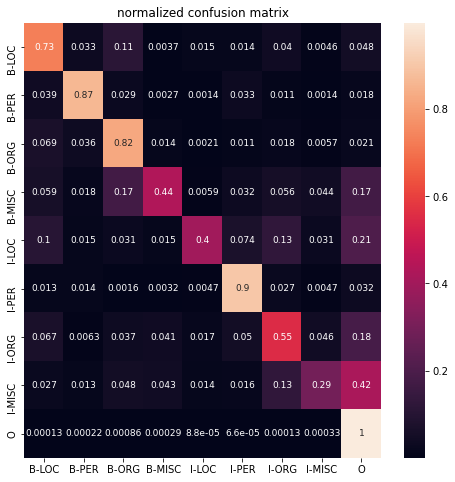

In [249]:
print_matrix(predictions_esp, y_esp_test)

Now we will look at the same feature exatraction but for the dutch dataset. It will be intresting to see the results, compare to the results we just received on the spanish dataset.


In [250]:
pipeline.fit(X_ned_train, y_ned_train)
predictions_ned = pipeline.predict(X_ned_test)

In [251]:
print_prediction(predictions_ned, y_ned_test)

accuracy:0.9743883847549909

              precision    recall  f1-score   support

       B-LOC      0.824     0.748     0.784       774
       B-PER      0.728     0.842     0.781      1098
       B-ORG      0.743     0.643     0.689       882
      B-MISC      0.790     0.703     0.744      1187
       I-LOC      0.657     0.469     0.548        49
       I-PER      0.723     0.884     0.795       807
       I-ORG      0.803     0.510     0.624       551
      I-MISC      0.691     0.344     0.459       410
           O      0.993     0.999     0.996     63117

    accuracy                          0.974     68875
   macro avg      0.772     0.682     0.713     68875
weighted avg      0.973     0.974     0.973     68875



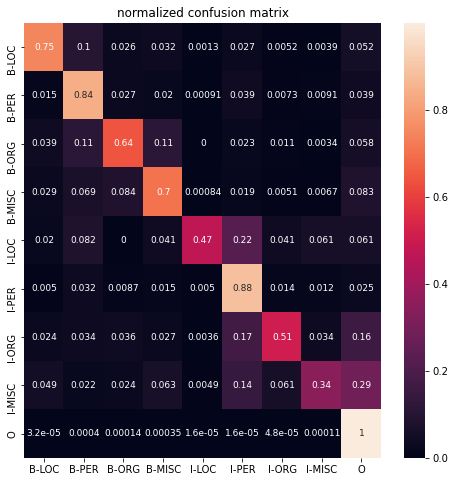

In [252]:
print_matrix(predictions_ned, y_ned_test)

We can tell that the results of the dutch dataset are better, although we used the same feature extraction. It implies that the features we chose are more informatic for dutch than for spanish, it is probably explained by the way those languages are 'built'. 



Now, we will try to improve the features extractor. We will add more features that will give us more information on the data.

In [253]:
def extract_more_features(sent, index):
    word = sent[index][0]
    postag = sent[index][1]
    spec = special_chars(word)
    features =  {'word': word, 'postag': postag, 'isNumber': word.isnumeric(), 'specialChars': spec, 'allCapital': word.isupper(),
           'capitalized': word[0].isupper(), 'prefix': word[:2], 'suffix2': word[-2:], 'suffix3': word[-3:]}
    
    # information about the previous word
    if index > 0:
        prev_word = sent[index-1][0]
        prev_postag = sent[index-1][1]
        features.update({'prevWord': prev_word, 'prevPostag': prev_postag})
    else:
        features.update({'prevWord': 'BOS', 'prevPostag': 'BOS'}) 
    
    # information about the next word
    if index < len(sent) -1:
        next_word = sent[index+1][0]
        next_postag = sent[index+1][1]
        features.update({'nextWord': next_word, 'nextPostag': next_postag})
    else:
        features.update({'nextWord': 'EOS', 'nextPostag': 'EOS'}) 
        
    return features

In [254]:
def show_data(sent):
    return [extract_more_features(sent, i) for i in range(len(sent))]

show_data(train_esp_sents[0])[0]

{'word': 'Melbourne',
 'postag': 'NP',
 'isNumber': False,
 'specialChars': False,
 'allCapital': False,
 'capitalized': True,
 'prefix': 'Me',
 'suffix2': 'ne',
 'suffix3': 'rne',
 'prevWord': 'BOS',
 'prevPostag': 'BOS',
 'nextWord': '(',
 'nextPostag': 'Fpa'}

In [255]:
def dicts_list(data):
    return sum([[extract_more_features(sent, i) for i in range(len(sent))] for sent in data],[])

And once again, we will extract features for our data so we could train a model with it.

In [256]:
X_esp_train = dicts_list(train_esp_sents)
y_esp_train = get_all_classes(train_esp_sents)

X_esp_test = dicts_list(test_esp_sents)
y_esp_test = get_all_classes(test_esp_sents)

X_esp_testa = dicts_list(testa_esp_sents)
y_esp_testa = get_all_classes(testa_esp_sents)

In [257]:
X_ned_train = dicts_list(train_ned_sents)
y_ned_train = get_all_classes(train_ned_sents)

X_ned_test = dicts_list(test_ned_sents)
y_ned_test = get_all_classes(test_ned_sents)

X_ned_testa = dicts_list(testa_ned_sents)
y_ned_testa = get_all_classes(testa_ned_sents)

In [258]:
pipeline.fit(X_esp_train, y_esp_train)
predictions_esp = pipeline.predict(X_esp_test)

In [259]:
print_prediction(predictions_esp, y_esp_test)

accuracy:0.9597927541575302

              precision    recall  f1-score   support

       B-LOC      0.738     0.732     0.735      1084
       B-PER      0.830     0.865     0.847       735
       B-ORG      0.784     0.823     0.803      1400
      B-MISC      0.563     0.437     0.492       339
       I-LOC      0.699     0.400     0.509       325
       I-PER      0.784     0.901     0.838       634
       I-ORG      0.726     0.551     0.626      1104
      I-MISC      0.603     0.294     0.396       557
           O      0.985     0.998     0.992     45355

    accuracy                          0.960     51533
   macro avg      0.746     0.667     0.693     51533
weighted avg      0.956     0.960     0.956     51533



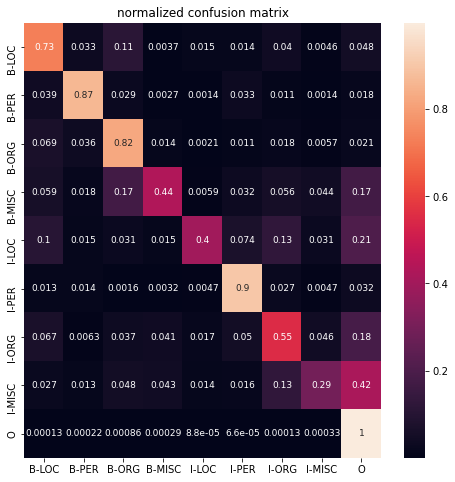

In [260]:
print_matrix(predictions_esp, y_esp_test)

In the spanish dataset the results are better now!

Let's look at the dutch dataset:

In [261]:
pipeline.fit(X_ned_train, y_ned_train)
predictions_ned = pipeline.predict(X_ned_test)

In [262]:
print_prediction(predictions_ned, y_ned_test)

accuracy:0.9743883847549909

              precision    recall  f1-score   support

       B-LOC      0.824     0.748     0.784       774
       B-PER      0.728     0.842     0.781      1098
       B-ORG      0.743     0.643     0.689       882
      B-MISC      0.790     0.703     0.744      1187
       I-LOC      0.657     0.469     0.548        49
       I-PER      0.723     0.884     0.795       807
       I-ORG      0.803     0.510     0.624       551
      I-MISC      0.691     0.344     0.459       410
           O      0.993     0.999     0.996     63117

    accuracy                          0.974     68875
   macro avg      0.772     0.682     0.713     68875
weighted avg      0.973     0.974     0.973     68875



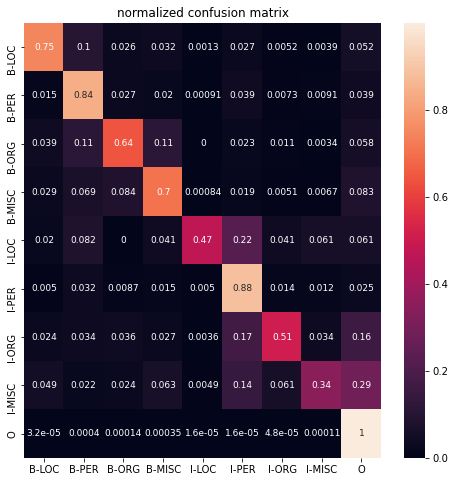

In [263]:
print_matrix(predictions_ned, y_ned_test)

The results are better also in dutch.

We can deduce from that - adding features with information on the previous and next words of each word, helps the model 'learn the datset' in a better way and improve the results.

<a name="q3.1.3"></a>
<h4>Q3.1.3 Greedy Tagging vs. Sequence Tagging</h4>

We implemented above a version of NER which is based on <i>greedy tagging</i>: that is, without optimizing the sequence of tags 
as we would obtain by training an HMM or CRF model.  
In particular, we did not check that the BIO tags produced by the tagger is a legal sequence.
Write code to identify sequences of BIO tags which are illegal and report on the frequency of this problem for each type
of illegal tags transition (O-IX, IX-IY, BX-IY).  Comment on your observations.

In [265]:
I_class = [label for label in classes if label[0]=='I']
B_class = [label for label in classes if label[0]=='B']
O_class = ['O']

In [266]:
def is_legal(prev, curr):
    # check if 2 adjencent tags are legal
    if prev in O_class and curr in I_class:
        return False
    if prev in I_class and curr in I_class and I_class.index(prev) != I_class.index(curr):
        return False
    if prev in B_class and curr in I_class and B_class.index(prev) != I_class.index(curr):
        return False
    else:
        return True

In [267]:
def illegal(data, pipeline):
    illegals = []
    for sent in data:
        # get the features
        features = extract_more_features(sent, 0)
        prev = pipeline.predict(features)[0]
        # run over all data extracted from the features extrctor and check if legal
        for index in range(1,len(sent)):
            features2 = extract_more_features(sent, index)
            curr = pipeline.predict(features2)[0]
            if not is_legal(prev, curr):
                # the 2 words are illegal with this tagging one after the other
                illegals.append({'lastTag':prev,'currentTag':curr,'lastType':prev[0],'currentType':curr[0],
                          'lastNER':'O' if prev=='O' else prev[2:], 'currentNER':'O' if curr=='O' else curr[2:],
                          'lastWord':features['word'],'currentWord':features2['word']})
            prev = curr
            features = features2
    # return all illegal occurrences
    return illegals

In [268]:
illegal_list = illegal(train_esp_sents, pipeline)

In [51]:
print(f'we found {len(illegal_list)} illegal tags transition')

we found 712 illegal tags transition


This is the distribution of illegal occurrences between the three different types

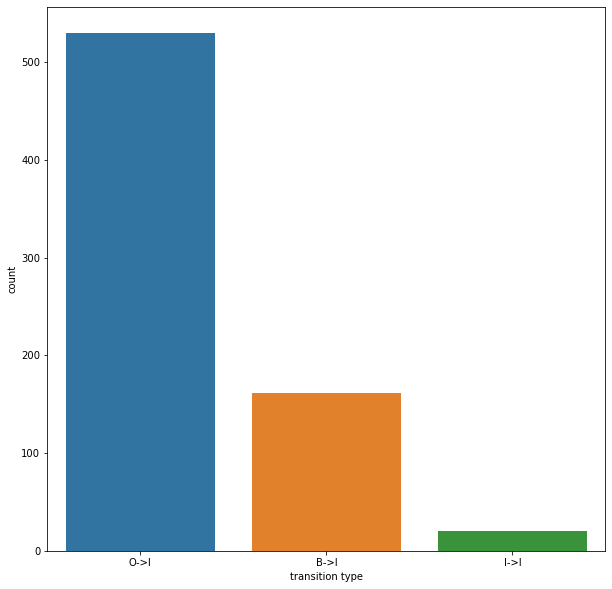

In [58]:
df = DataFrame(illegal_list)
fig1 = plt.figure('Transition types', [10,10])
df['transition type'] = df['lastType'] + '->' + df['currentType']
fig1 = sns.countplot(x='transition type', data=df)

Now we want to look at the different distributions inside each of the illegal types:

[]

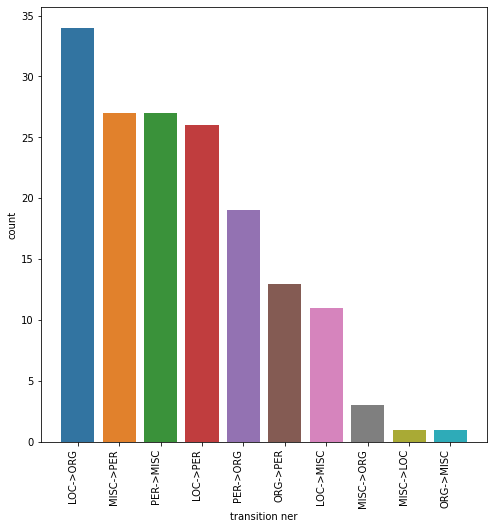

In [64]:
df['transition ner'] = df['lastNER'] + '->' + df['currentNER']
bi_df = df[df['transition type']=='B->I']
fig1 = plt.figure('Transition types', [8, 8])
fig1 = sns.countplot(x='transition ner', order = bi_df['transition ner'].value_counts().index, data=bi_df)
fig1.set_xticklabels(fig1.get_xticklabels(), rotation=90, ha="right")
fig1.plot()

We can see that from LOC to ORG repeats much more than the oters

[]

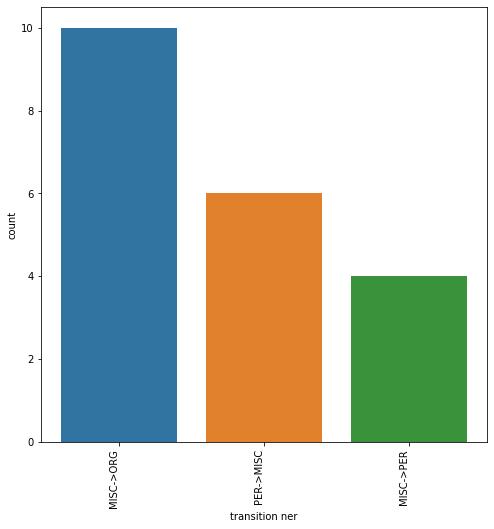

In [66]:
ii_df = df[df['transition type']=='I->I']
fig1 = plt.figure('Transition types', [8, 8])
fig1 = sns.countplot(x='transition ner', order = ii_df['transition ner'].value_counts().index, data=ii_df)
fig1.set_xticklabels(fig1.get_xticklabels(), rotation=90, ha="right")
fig1.plot()

[]

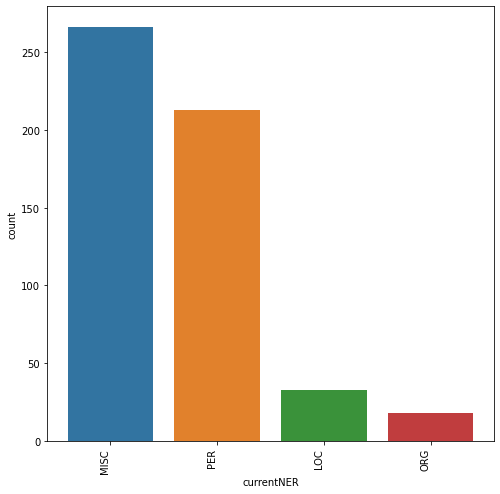

In [68]:
oi_df = df[df['transition type']=='O->I']
fig1 = plt.figure('Transition types', [8, 8])
fig1 = sns.countplot(x='currentNER', order = oi_df['currentNER'].value_counts().index, data=oi_df)
fig1.set_xticklabels(fig1.get_xticklabels(), rotation=90, ha="right")
fig1.plot()

This is how it looks overall, between all the different illegal options.

O->I MISC, O -> I PER

this types repeats a lot more time than all the others.

[]

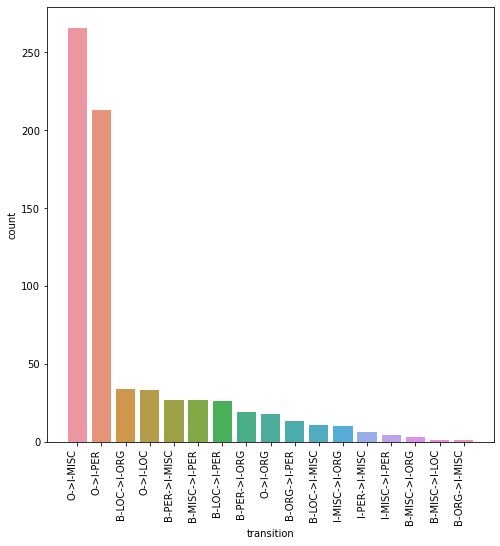

In [69]:
df['transition'] = df['lastTag'] + '->' + df['currentTag']
fig1 = plt.figure('Transition types', [8, 8])
fig1 = sns.countplot(x='transition', order = df['transition'].value_counts().index, data=df)
fig1.set_xticklabels(fig1.get_xticklabels(), rotation=90, ha="right")
fig1.plot()

<a name="q3.2"></a>
<h3>Q3.2 Using Word Embeddings</h3>

One way to improve a greedy tagger for NER is to use Word Embeddings as features.
A convenient package to manipulate Word2Vec word embeddings is provided in the <a href="https://radimrehurek.com/gensim/">gensim</a> package by Radim Rehurek.
To install it, use:

In [359]:
!pip install gensim

You must also download a pre-trained Word2Vec or fastText word embedding model.
The models must naturally be in Spanish or Dutch. (Only test word embeddings for one language.)
You can find pre-trained word embedding models in different formats:
<ol>
<li><a href="https://github.com/facebookresearch/fastText/blob/master/docs/pretrained-vectors.md">fastText pretrained models</a> (includes models for 294 languages)
<li><a href="https://github.com/uchile-nlp/spanish-word-embeddings">Spanish Word2vec models</a> 
</ol>

Specific information on manipulating word vectors with Gensim is provided in Gensim with the <a href="https://radimrehurek.com/gensim/models/keyedvectors.html">KeyedVector</a>.
Practical examples are available for Spanish in this <a href="https://github.com/uchile-nlp/spanish-word-embeddings/blob/master/examples/Ejemplo_WordVectors.ipynb">notebook</a>.
(Pay attention that word embeddings large are pretty big files - about 3GB when uncompressed.)

Your task:
<ol>
<li>Add word embeddings as dense vectors to the features of your NER classifier for each word feature (current word, previous word, next word) - either in Spanish or in Dutch.
<li>Retrain the model and report on performance.  Comment.
</ol>

In [360]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
from gensim.models import Word2Vec
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.pipeline import FeatureUnion

In [361]:
# create vector from the words in the dataset
wordvectors_file_vec = 'data/wiki.es.vec'
wordvectors = KeyedVectors.load_word2vec_format(wordvectors_file_vec, binary=False)

In [362]:
len_test = len(X_esp_test)
not_embedded = len([w for w in X_esp_test if w['word'].lower() not in wordvectors])
print(f'the precentage of words in test dataset but not in the embedding: {not_embedded/len_test}')

the precentage of words in test dataset but not in the embedding: 0.02990316884326548


Let's take a look at the object we just created:

In [363]:
wordvectors.vocab

{'de': <gensim.models.keyedvectors.Vocab at 0x2eb0fb264c0>,
 '</s>': <gensim.models.keyedvectors.Vocab at 0x2eb0fb26670>,
 ',': <gensim.models.keyedvectors.Vocab at 0x2eb0fb14f10>,
 '.': <gensim.models.keyedvectors.Vocab at 0x2eb0fb145b0>,
 'la': <gensim.models.keyedvectors.Vocab at 0x2eb0fb14c40>,
 'en': <gensim.models.keyedvectors.Vocab at 0x2eb0fb14b50>,
 'el': <gensim.models.keyedvectors.Vocab at 0x2eb0fb14b20>,
 'y': <gensim.models.keyedvectors.Vocab at 0x2eb0fb14490>,
 '-': <gensim.models.keyedvectors.Vocab at 0x2eb0fb14130>,
 ')': <gensim.models.keyedvectors.Vocab at 0x2eb0fb146a0>,
 'a': <gensim.models.keyedvectors.Vocab at 0x2eb0fb14670>,
 '(': <gensim.models.keyedvectors.Vocab at 0x2eb0fb14580>,
 'que': <gensim.models.keyedvectors.Vocab at 0x2eb0fb146d0>,
 "'": <gensim.models.keyedvectors.Vocab at 0x2eb0fb14430>,
 'del': <gensim.models.keyedvectors.Vocab at 0x2eb110b7b80>,
 'los': <gensim.models.keyedvectors.Vocab at 0x2eb110b7730>,
 'se': <gensim.models.keyedvectors.Vocab at

and how each word is represented in the vector?

In [364]:
wordvectors['que']

array([-3.8702e-02,  8.6242e-03,  7.7157e-04,  1.1074e-02,  1.4201e-01,
        1.2204e-01, -4.9101e-03,  1.7932e-01, -2.4330e-02, -3.0732e-01,
       -7.0185e-02,  4.1497e-02,  2.7147e-02, -3.9159e-02, -8.0597e-02,
        7.0478e-02,  8.3426e-02, -3.0201e-02, -2.1576e-01,  3.8433e-03,
       -6.1426e-02, -2.8136e-02,  2.0878e-02, -2.4300e-01,  1.7287e-01,
       -1.2883e-01, -7.6604e-03, -1.0034e-01, -2.2452e-01, -7.6677e-02,
       -1.2778e-01,  1.2221e-01, -1.0095e-01, -9.3849e-02,  1.0530e-01,
       -1.2211e-02, -2.3614e-01, -3.1510e-02, -1.5168e-01,  1.8146e-01,
       -8.8749e-02, -6.2043e-02, -1.1807e-02, -1.6943e-01,  3.7954e-02,
       -5.0114e-02, -7.7692e-03,  2.7901e-02, -5.8757e-02,  1.3625e-01,
       -2.5276e-01, -2.0305e-02, -1.6100e-01,  1.1873e-02, -6.1759e-02,
       -1.1908e-01, -3.7837e-02, -2.4540e-03,  8.8556e-02, -1.0373e-01,
       -4.3333e-02,  1.9475e-02,  1.0165e-01, -9.5659e-02,  2.1836e-01,
       -2.7419e-01, -1.2671e-01,  1.9737e-02, -1.4476e-01, -6.49

We want to ad to the feature vector the word embeddings. In order to do that we will create a new transformer function that will extend the feature vector we created before.

This class represented the model with the change of the feature vector.

In [386]:
class EmbedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, word2vec, kword):
        self.word2vec = word2vec
        self.len_vector = len(word2vec['uno'])
        self.word = kword
    
    def transform(self, X, **transform_params):
        return np.array([np.zeros(self.len_vector, dtype='float32') if x[self.word] not in self.word2vec 
                         else self.word2vec[x[self.word].lower()] for x in X], dtype='float32')

    def fit(self, X, y=None, **fit_params):
        return self
        

In [387]:
def create_pipeline_embedded():
    # this pipeline contains information about current word, and also previous and next ones.
    pipeline = Pipeline([
        ('features', FeatureUnion([
            ('vectorizer', DictVectorizer(sparse=True)),
            ('embedding_word', EmbedTransformer(wordvectors, kword='word')),
            ('embedding_next', EmbedTransformer(wordvectors, kword='nextWord')),
            ('embedding_prev', EmbedTransformer(wordvectors, kword='prevWord'))
        ])),
        ('classifier', LogisticRegression(solver='sag', max_iter=100))
    ])
    return pipeline

In [388]:
pipeline = create_pipeline_embedded()


In [389]:
pipeline.fit(X_esp_train,y_esp_train)


C:\Users\yaelj\miniconda3\envs\nlp21\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\yaelj\miniconda3\envs\nlp21\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('vectorizer',
                                                 DictVectorizer()),
                                                ('embedding_word',
                                                 EmbedTransformer(kword=None,
                                                                  word2vec=<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x000002EB10405400>)),
                                                ('embedding_next',
                                                 EmbedTransformer(kword=None,
                                                                  word2vec=<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x000002EB10405400>)),
                                                ('embedding_prev',
                                                 EmbedTransformer(kword=None,
                                                                  word2vec=<gensim.models.k

In [390]:
predictions_esp = pipeline.predict(X_esp_test)

In [391]:
print_prediction(predictions_esp, y_esp_test)

accuracy:0.9590553625831991

              precision    recall  f1-score   support

       B-LOC      0.706     0.692     0.699      1084
       B-PER      0.789     0.839     0.813       735
       B-ORG      0.771     0.827     0.798      1400
      B-MISC      0.534     0.469     0.499       339
       I-LOC      0.651     0.425     0.514       325
       I-PER      0.846     0.913     0.879       634
       I-ORG      0.718     0.582     0.643      1104
      I-MISC      0.573     0.294     0.389       557
           O      0.987     0.997     0.992     45355

    accuracy                          0.959     51533
   macro avg      0.731     0.671     0.692     51533
weighted avg      0.955     0.959     0.956     51533



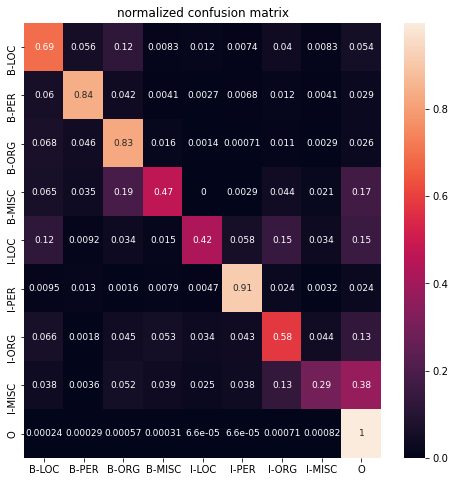

In [392]:
print_matrix(predictions_esp, y_esp_test)

We can see that this results are better than the results we recieved from our first featues extractor, but the second feature extractor we wrote is still better than this one. We deduce from this that data on the 'surrounding environment' of a word helps a lot to learn better and improve the accuracy.

Word embeddings capture the semantic meaning of the word, so we cocnlude that the words around each word we examine helps to understand and capture better the semantic meaning of the word.